# Dictionary Initialization

In [1]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the hybrid predictor
betaValues = []
hybridMeanRegretValues = []
hybridMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

rwValues = []

# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2024-05-21 00:00:00
len of test dataset:  675

total dataset lenght:  3620
sum of the three datasets:  3620
original returns dataframe dimension: (3620, 9)


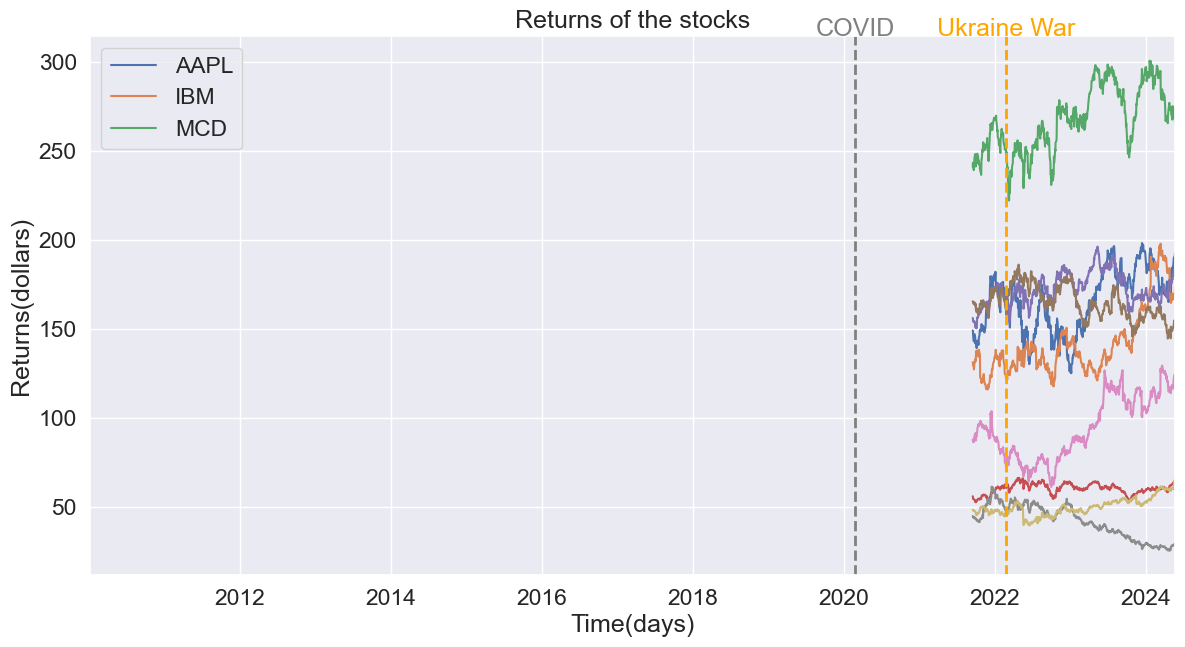

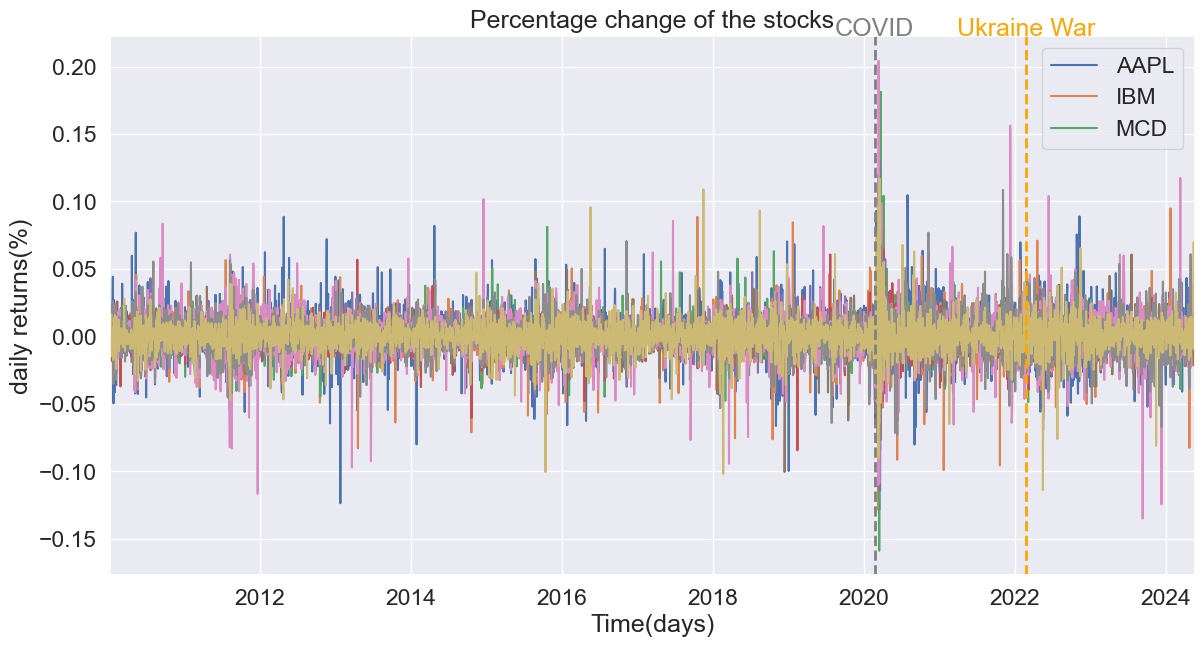

2010-01-04 00:00:00           7         20990     21177     20468     21384     21018     8045   \
7      0.000301  0.000114  0.000060  0.000044  0.000069  0.000056  0.000111   
20990  0.000114  0.000102  0.000041  0.000045  0.000053  0.000039  0.000084   
21177  0.000060  0.000041  0.000071  0.000036  0.000033  0.000015  0.000031   
20468  0.000044  0.000045  0.000036  0.000117  0.000050  0.000044  0.000049   
21384  0.000069  0.000053  0.000033  0.000050  0.000075  0.000030  0.000062   
21018  0.000056  0.000039  0.000015  0.000044  0.000030  0.000048  0.000045   
8045   0.000111  0.000084  0.000031  0.000049  0.000062  0.000045  0.000147   
21394  0.000101  0.000072  0.000029  0.000052  0.000051  0.000049  0.000088   
21880  0.000044  0.000026  0.000033  0.000036  0.000034  0.000016  0.000036   

          21394     21880  
7      0.000101  0.000044  
20990  0.000072  0.000026  
21177  0.000029  0.000033  
20468  0.000052  0.000036  
21384  0.000051  0.000034  
21018  0.000049  0.00

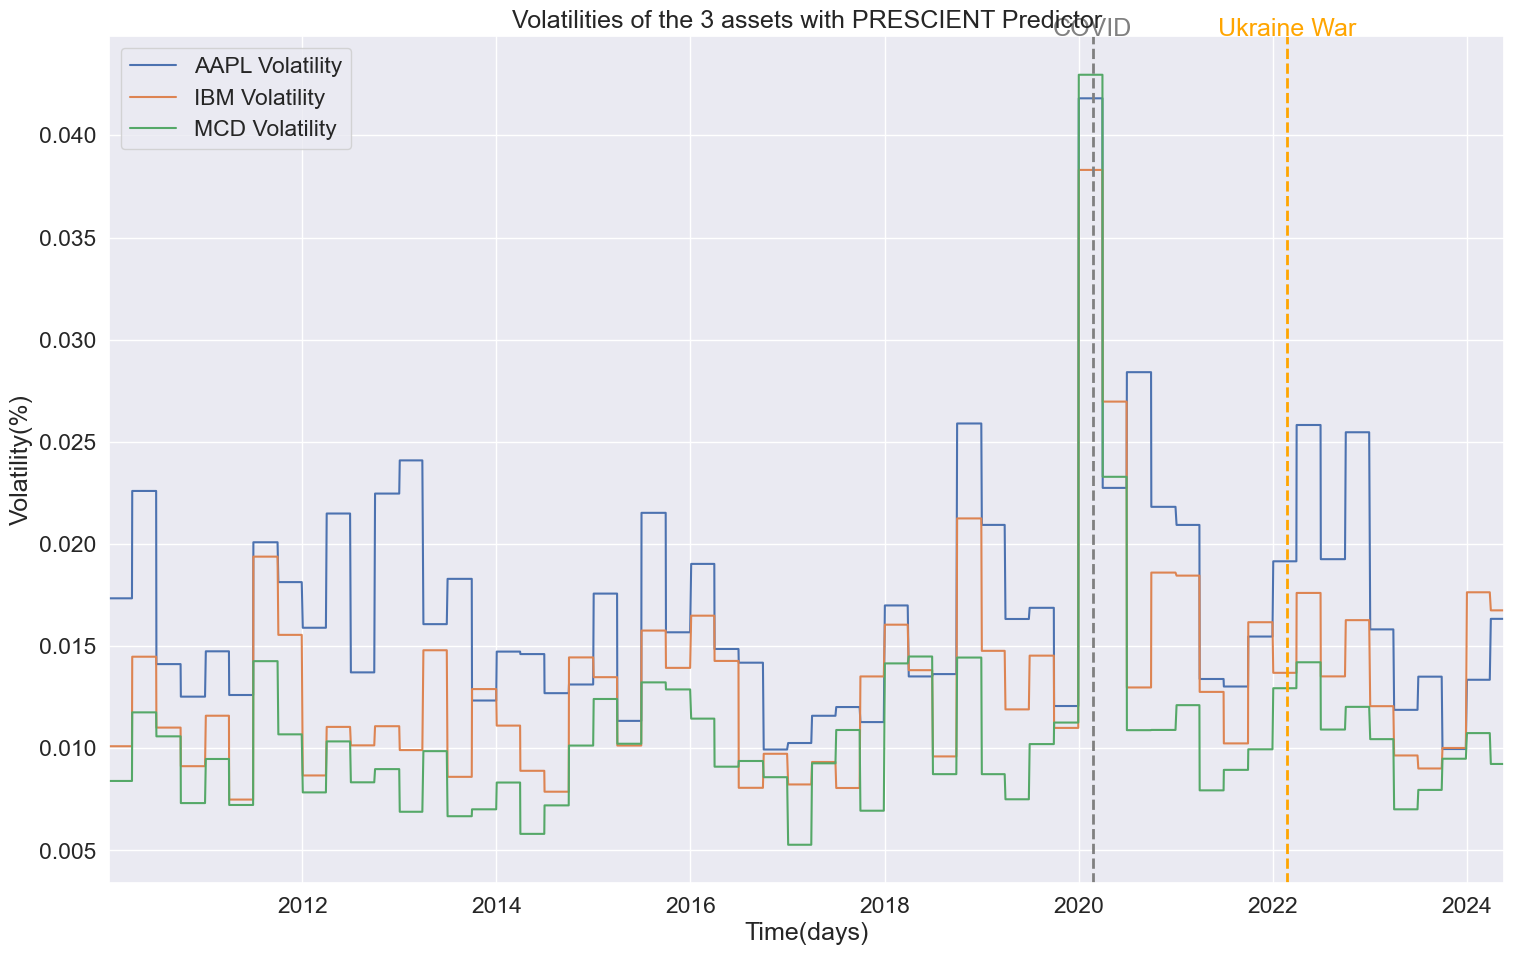

In [2]:
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

increment_type = "linear"
k = 10 # this parameter adjust the stepness of the curve "lamda increment" in the hybrid predictor

# Covariance Predictors

HYBRID MODEL PREDICTOR IMPLEMENTATION -> covMatrix = (1-x) * K + x * H

Where:
1. K is the covariance matrix calculated using a predictor like RW, EWMA, MGARCH 
2. H is the covariance matrix of the ExpandingWindow model
3. x is a weight between 0 and 1; 0 at the beginning of the quarter and 1 at the end of the quarter

# Validation Phase for Hybrid Model predictor (EW + RW)

In [3]:
# Loop through rw_memory values

def hybridPredictorValidationPhaseWithRw(rw_memory, startingDate, endingDate, rw_size_increment, prescientAlreadyPrinted, expandingWindowDict):
    '''
    this function is used to perform the validation phase of the RW predictor; it's used to find the best memory size of the window for the rw predictor.
    Grid search is used and the performance of the M hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''
    kValue = 0
    bestValueFounded = False


    while kValue < 1000:
        print("trying with k = " + str(kValue))
        rw_memory = 0

        while rw_memory < 1000 and bestValueFounded == False:
            # Increment beta
            rw_memory += rw_size_increment
            rwDict = rolling_window(validationDataWithPercentageChange, rw_memory) 

            #
            # DEFINE END AND START DATES FOR BACKTESTS
            #
                
            start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
            end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

            # filter the rwDict dictionary to have only the timestamps between the start and end date
            rwDict = {t: rwDict[t] for t in rwDict.keys() if t >= start_date and t <= end_date}

            # filter the expandingWindowDict dictionary to have only the timestamps between the start and end date
            expandingWindowDict = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

            # filter the dataset to have only the timestamps between the start and end date
            filteredDataset = stocksPercentageChangeReturn.loc[start_date:end_date]

            # now i can get the hybrid predictor covariance matrixes, this because i have the ewma and prescient covariance matrixes filtered by the start and end date(validation period)
            hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, filteredDataset, expandingWindowDict, rwDict, start_date, increment_type, k = kValue)

            names = ["HYBRID", "PRESCIENT"]

            #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
            predictors_temp = [hybridModelDict, prescientDict]
            predictors = [] # so this is a list of dictionaries

            for predictor in predictors_temp:
                predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

            #
            # LOG-LIKELIHOODS
            #

            '''
                this dictionary has a shape like this:
                {
                    RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                    EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                    MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                    PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                }

                where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
            '''

            for i, predictorDict in enumerate(predictors):

                returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
                times = pd.Series(predictorDict).index[1:]
                Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
                daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

            #
            # REGRETS
            #

            for name in daily_log_likelihoods:
                daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]

            
            # copy the log-likelihoods dictionary
            daily_log_likelihoods_copy = daily_log_likelihoods.copy()
            prescientMeanlogLikelihoodValues = []
            bestAverageLogLikelihood = 0
            bestAverageRegret = 100000

            # do the same thing for log-likelihoods dictionary
            for name in daily_log_likelihoods_copy:
                quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
                logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

                if name != "PRESCIENT":
                    # save the log-likelihood mean values to plot a chart
                    hybridMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                    bestAverageLogLikelihood = logLikelihoodMetrics[0]

                if name == "PRESCIENT":
                # i'm writing the prescient predictor only once, because it's the same for every rw_memory value

                    # save the loglikelihood mean value to plot a chart
                    prescientMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])

            index = int((numberOfAssets / 3) - 1)
            if bestAverageLogLikelihood <= mean_loglikelihood['H_RW'][index]:
                continue

            # if i arrive here it means that there is an M value for which the mean loglikelihood is greater then the best that i've found until now
            # so i proceed to check if also the regret is better than the best that i've found until now

            for name in daily_regrets:
                if name != "PRESCIENT":

                    #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                    quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                    # so the regret variable is a series of average regret for each quarter
                    
                    regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                    # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                    # save the regret mean values to plot a chart
                    hybridMeanRegretValues.append(regretMetrics[0])
                    bestAverageRegret = regretMetrics[0]



            index = int((numberOfAssets / 3) - 1)
            if bestAverageRegret < mean_regret['H_RW'][index]:
                # if i arrive here it means that there is an M value for which the mean loglikelihood and mean regret are greater then the best that i've found until now
                # so print the M value
                print("BEST rw_memory: " + str(rw_memory))
                print("print the best average loglikelihood: " + str(bestAverageLogLikelihood))
                print("actual best average loglikelihood: " + str(mean_loglikelihood['H_RW'][index]))
                print("print the best average regret: " + str(bestAverageRegret))
                print("actual best average regret: " + str(mean_regret['H_RW'][index]))
                print("\n")
                bestValueFounded = True

            else:
                # skip the rest of the loop and go to the next iteration
                continue
            
            # save the rw value to plot a chart
            rwValues.append(rw_memory)
        
        kValue += 5

    print("dimension of hybridDict: " + str(len(hybridModelDict)))
    print("first timestamp of hybridDict: " + str(list(hybridModelDict.keys())[0]))
    print("last timestamp of hybridDict: " + str(list(hybridModelDict.keys())[-1]))
    
    # return the fundamental values to plot the charts
    return rwValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues

In [4]:
'''
# grid search run for the RW predictor
rwValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues = hybridPredictorValidationPhaseWithRw(0, startingValidationDate, endingValidationDate, 5, prescientAlreadyPrinted, expandingWindowDict)

# plot the performance of the RW predictor in terms of log-likelihood and regret
plotPerformancePredictor(rwValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues, hybridMeanRegretValues, "Hybrid(RW)", "Memory size M")
'''

'\n# grid search run for the RW predictor\nrwValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues = hybridPredictorValidationPhaseWithRw(0, startingValidationDate, endingValidationDate, 5, prescientAlreadyPrinted, expandingWindowDict)\n\n# plot the performance of the RW predictor in terms of log-likelihood and regret\nplotPerformancePredictor(rwValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues, hybridMeanRegretValues, "Hybrid(RW)", "Memory size M")\n'

In [5]:
# write the value of regret and loglikelihood for the rw memory value = 130
# take the index for which the rw memory is 130
'''
index = rwValues.index(30)
print("index value: ", index)
print("hybridMeanRegretValues: " + str(hybridMeanRegretValues[index]))
print("hybridMeanlogLikelihoodValues: " + str(hybridMeanlogLikelihoodValues[index]))
'''


'\nindex = rwValues.index(30)\nprint("index value: ", index)\nprint("hybridMeanRegretValues: " + str(hybridMeanRegretValues[index]))\nprint("hybridMeanlogLikelihoodValues: " + str(hybridMeanlogLikelihoodValues[index]))\n'

# Test Phase for Hybrid Model predictor (EW + RW)

In [6]:
# calculate the rolling window predictor inside the test phase
start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

# select the best memory size for the RW predictor
rw_memory = predictorsConfiguration["HYBRIDRW_memorySize"]

rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

# filter the rwDict dictionary to have only the timestamps between the start and end date
rwDict = {t: rwDict[t] for t in rwDict.keys() if t >= start_date and t <= end_date}

print("len of the rwDict dictionary: " + str(len(rwDict)))

# print the first key of the dictionary
print("first timestamp of rwDict: " + str(list(rwDict.keys())[0]))
print(rwDict[list(rwDict.keys())[0]])


len of the rwDict dictionary: 656
first timestamp of rwDict: 2021-10-12 00:00:00
          7         20990     21177     20468     21384     21018     8045   \
7      0.000148  0.000045  0.000067  0.000064  0.000064  0.000045  0.000098   
20990  0.000045  0.000119  0.000036  0.000035  0.000008  0.000005  0.000089   
21177  0.000067  0.000036  0.000066  0.000030  0.000032  0.000022  0.000072   
20468  0.000064  0.000035  0.000030  0.000058  0.000049  0.000017  0.000064   
21384  0.000064  0.000008  0.000032  0.000049  0.000069  0.000025  0.000059   
21018  0.000045  0.000005  0.000022  0.000017  0.000025  0.000046  0.000034   
8045   0.000098  0.000089  0.000072  0.000064  0.000059  0.000034  0.000272   
21394  0.000054  0.000017  0.000013  0.000028  0.000028  0.000036  0.000032   
21880  0.000052 -0.000024  0.000026  0.000019  0.000032  0.000030  0.000015   

          21394     21880  
7      0.000054  0.000052  
20990  0.000017 -0.000024  
21177  0.000013  0.000026  
20468  0.000028 

In [7]:
# filter the expandingWindowDict dictionary to have only the timestamps between the start and end date ( for the test phase)

expandingWindowDictForTest = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

print("len of the expandingWindowDict dictionary: " + str(len(expandingWindowDictForTest)))
print("first timestamp of expandingWindowDict: " + str(list(expandingWindowDictForTest.keys())[0]))
print(expandingWindowDictForTest[list(expandingWindowDictForTest.keys())[0]])

len of the expandingWindowDict dictionary: 675
first timestamp of expandingWindowDict: 2021-09-15 00:00:00
          7         20990     21177     20468     21384     21018     8045   \
7      0.000165  0.000018  0.000046  0.000039  0.000024  0.000047  0.000069   
20990  0.000018  0.000106  0.000027  0.000021  0.000005  0.000006  0.000008   
21177  0.000046  0.000027  0.000075  0.000038  0.000024  0.000026  0.000024   
20468  0.000039  0.000021  0.000038  0.000057  0.000042  0.000032  0.000029   
21384  0.000024  0.000005  0.000024  0.000042  0.000054  0.000027  0.000017   
21018  0.000047  0.000006  0.000026  0.000032  0.000027  0.000058  0.000048   
8045   0.000069  0.000008  0.000024  0.000029  0.000017  0.000048  0.000175   
21394  0.000049  0.000013 -0.000009  0.000015  0.000008  0.000057  0.000052   
21880  0.000027  0.000011  0.000016  0.000028  0.000025  0.000028  0.000011   

          21394     21880  
7      0.000049  0.000027  
20990  0.000013  0.000011  
21177 -0.000009  0

In [8]:
# HYBRID MODEL IMPLEMENTATION
# i have defined inside the 2 box above the expanding window and the rw predictors; now i will use them to implement the hybrid model

# the hybrid model is a combination of the expanding window and the rw predictors; the lambda parameter is incremented linearly in each quarter. so it is like the inverse of the number of days in a quarter
hybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDictForTest, rwDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(rwDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])

dimension of the hybrid model dictionary: 656
first 3 elements of the hybrid model dictionary: 
2021-10-12 00:00:00           7         20990     21177     20468     21384     21018     8045   \
7      0.000148  0.000045  0.000067  0.000064  0.000064  0.000045  0.000097   
20990  0.000045  0.000120  0.000036  0.000035  0.000008  0.000005  0.000089   
21177  0.000067  0.000036  0.000065  0.000030  0.000032  0.000022  0.000071   
20468  0.000064  0.000035  0.000030  0.000057  0.000049  0.000017  0.000064   
21384  0.000064  0.000008  0.000032  0.000049  0.000069  0.000025  0.000059   
21018  0.000045  0.000005  0.000022  0.000017  0.000025  0.000046  0.000034   
8045   0.000097  0.000089  0.000071  0.000064  0.000059  0.000034  0.000273   
21394  0.000054  0.000017  0.000013  0.000028  0.000028  0.000036  0.000031   
21880  0.000052 -0.000025  0.000026  0.000019  0.000032  0.000030  0.000014   

          21394     21880  
7      0.000054  0.000052  
20990  0.000017 -0.000025  
21177  0.

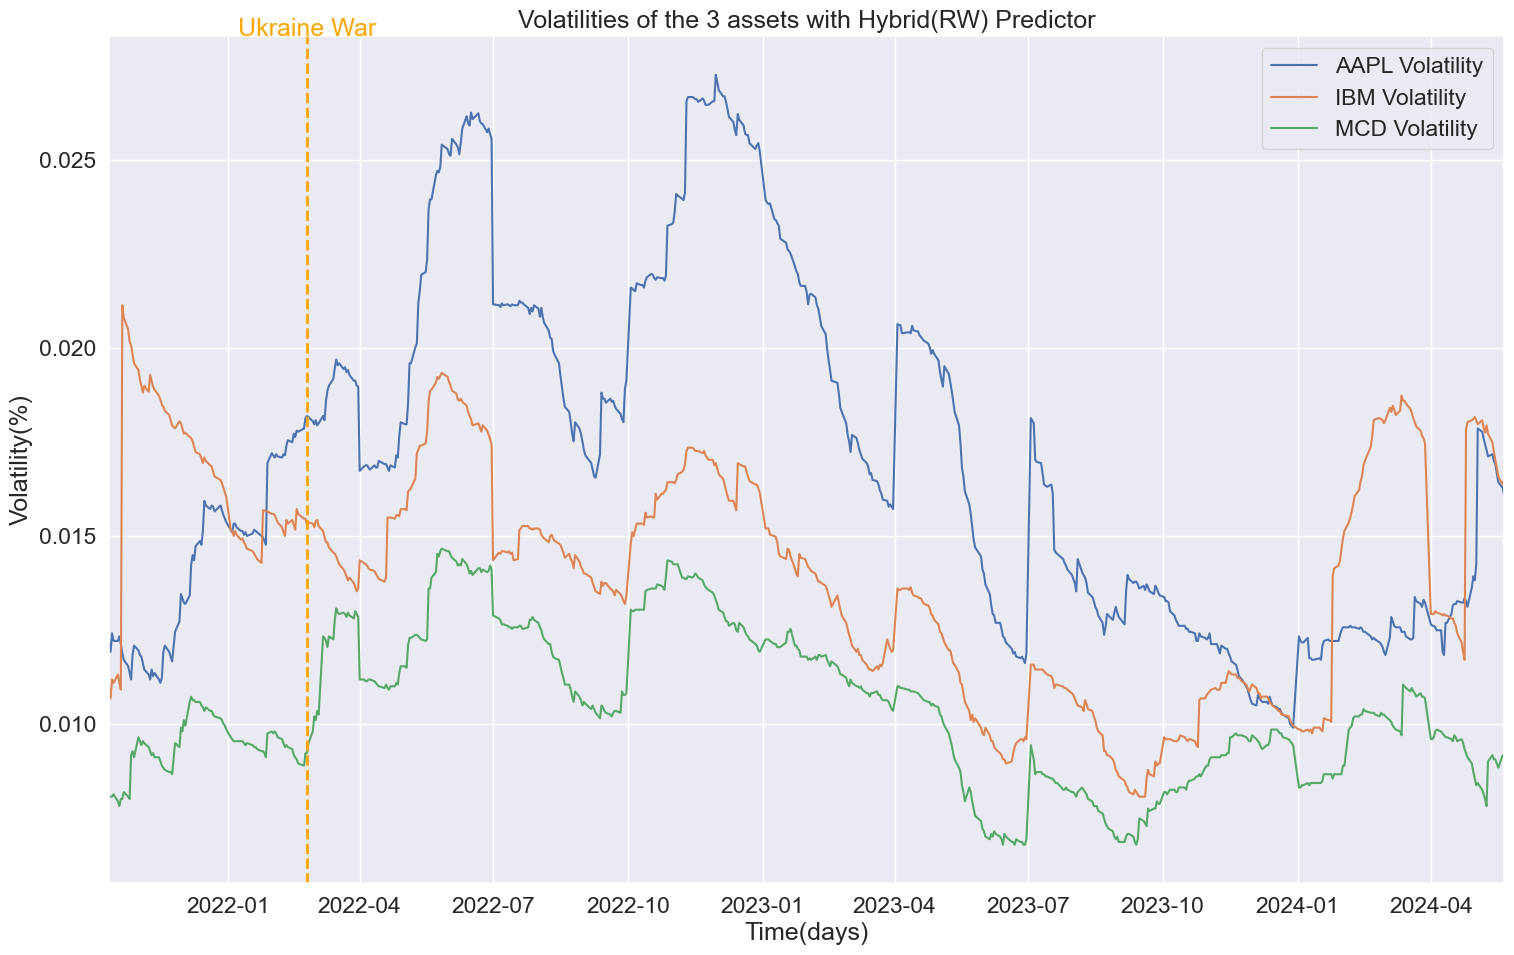

In [9]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# assets names are AAPL, IBM, MCD, KO, PEP, JNJ, ORCL, PFE, WMT
df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd,  df_hybrid_volatility_ko, df_hybrid_volatility_pep, df_hybrid_volatility_jnj, df_hybrid_volatility_orcl, df_hybrid_volatility_pfe, df_hybrid_volatility_wmt, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd, hybrid_volatility_dict_ko, hybrid_volatility_dict_pep, hybrid_volatility_dict_jnj, hybrid_volatility_dict_orcl, hybrid_volatility_dict_pfe, hybrid_volatility_dict_wmt = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(RW)')

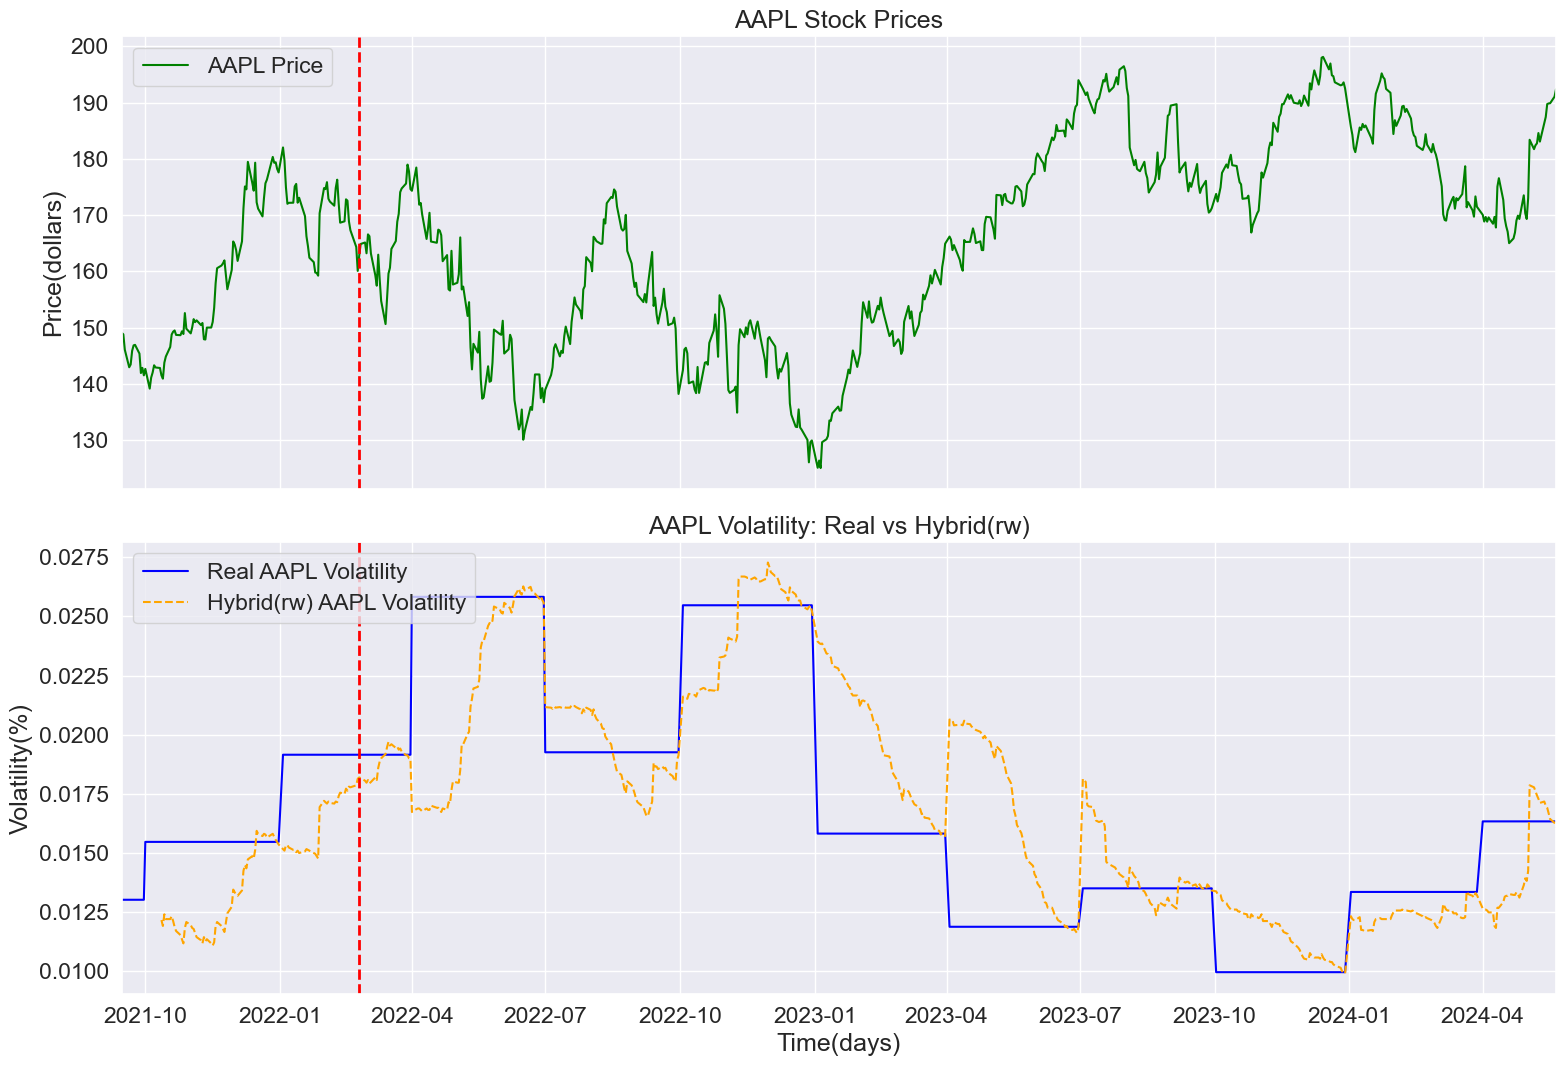

In [10]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "Hybrid(rw)")

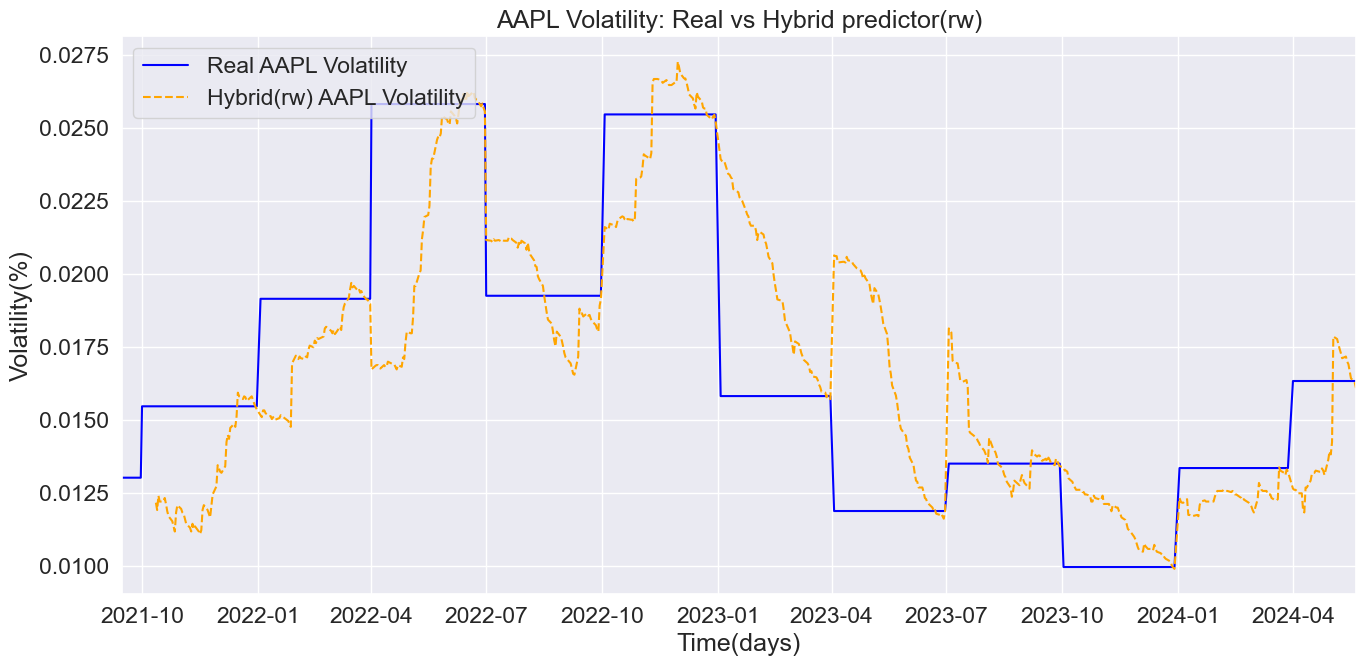

In [11]:
####################### code for test ####################################

def plot_prices_volatilities_for_ewAndRWTest(real_volatility, real_volatility_startDate, real_volatility_endDate, hybrid_volatility, asset_name):
    # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]

    plt.figure(figsize=(14, 7))

    # Plot real and rolling window volatilities
    plt.plot(real_volatility_filtered, label='Real AAPL Volatility', color='blue')
    plt.plot(hybrid_volatility, label='Hybrid(rw) AAPL Volatility', color='orange', linestyle='--')
    plt.title('AAPL Volatility: Real vs Hybrid predictor(rw)')
    plt.xlabel('Time(days)')
    plt.ylabel('Volatility(%)')
    plt.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Show the plot
    plt.tight_layout()
    plt.show()


# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewAndRWTest(df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL')
##########################################################################

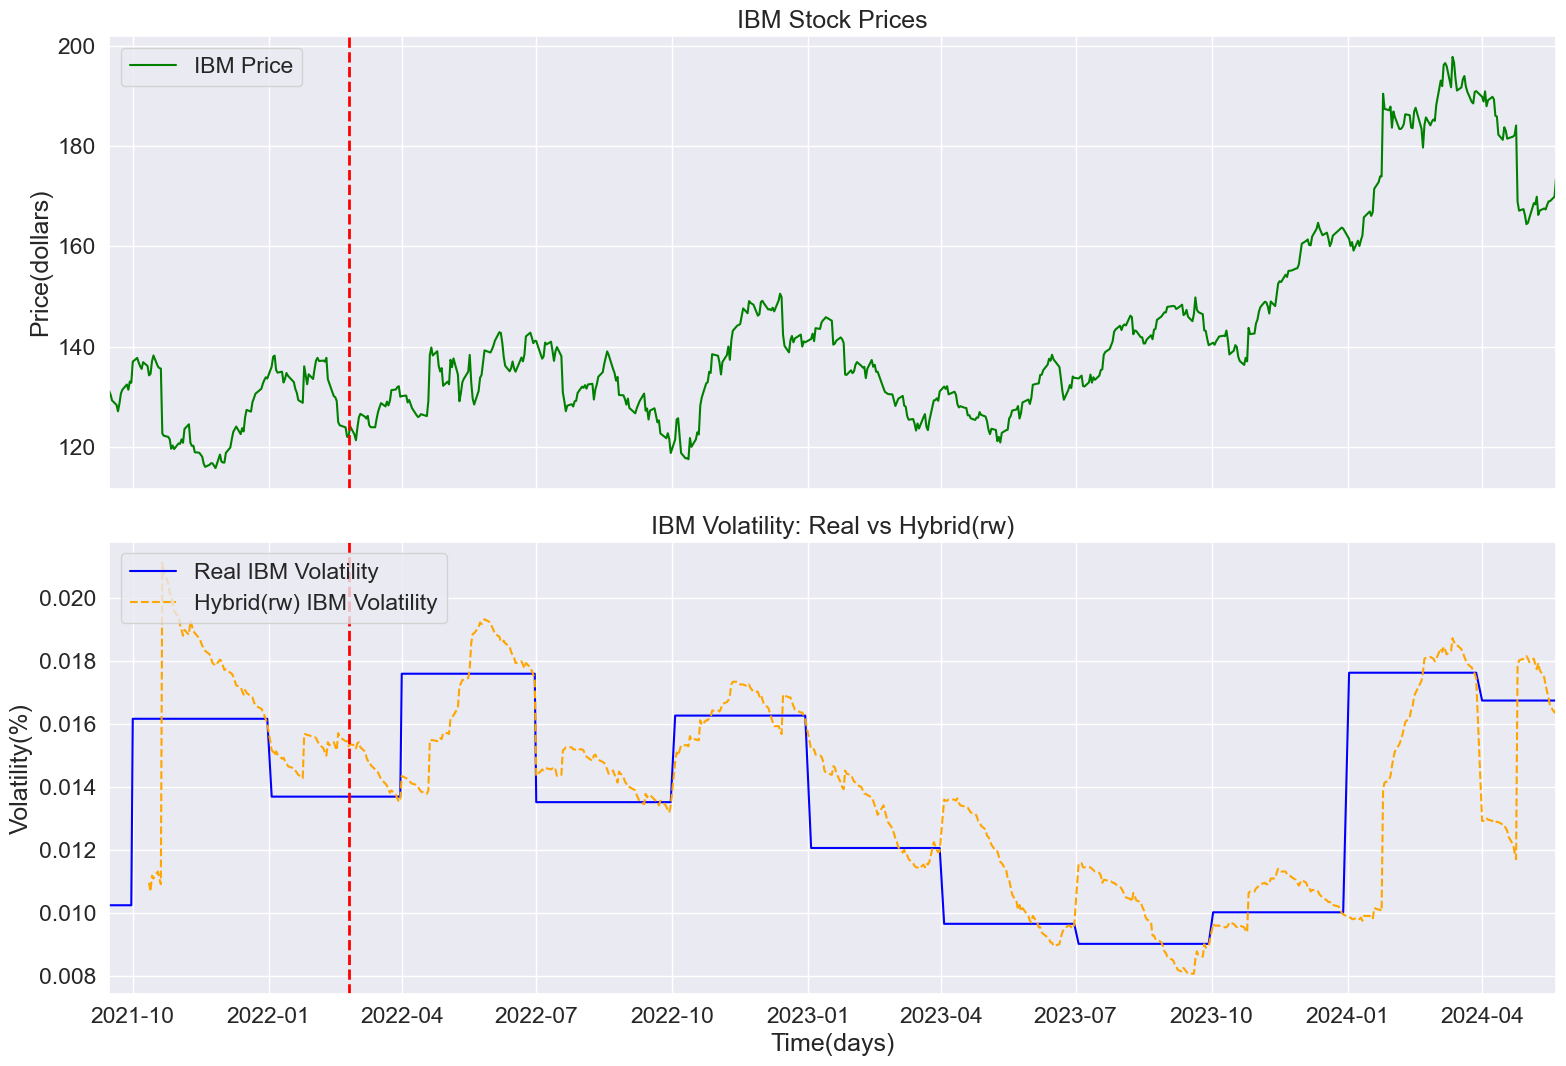

In [12]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "Hybrid(rw)")

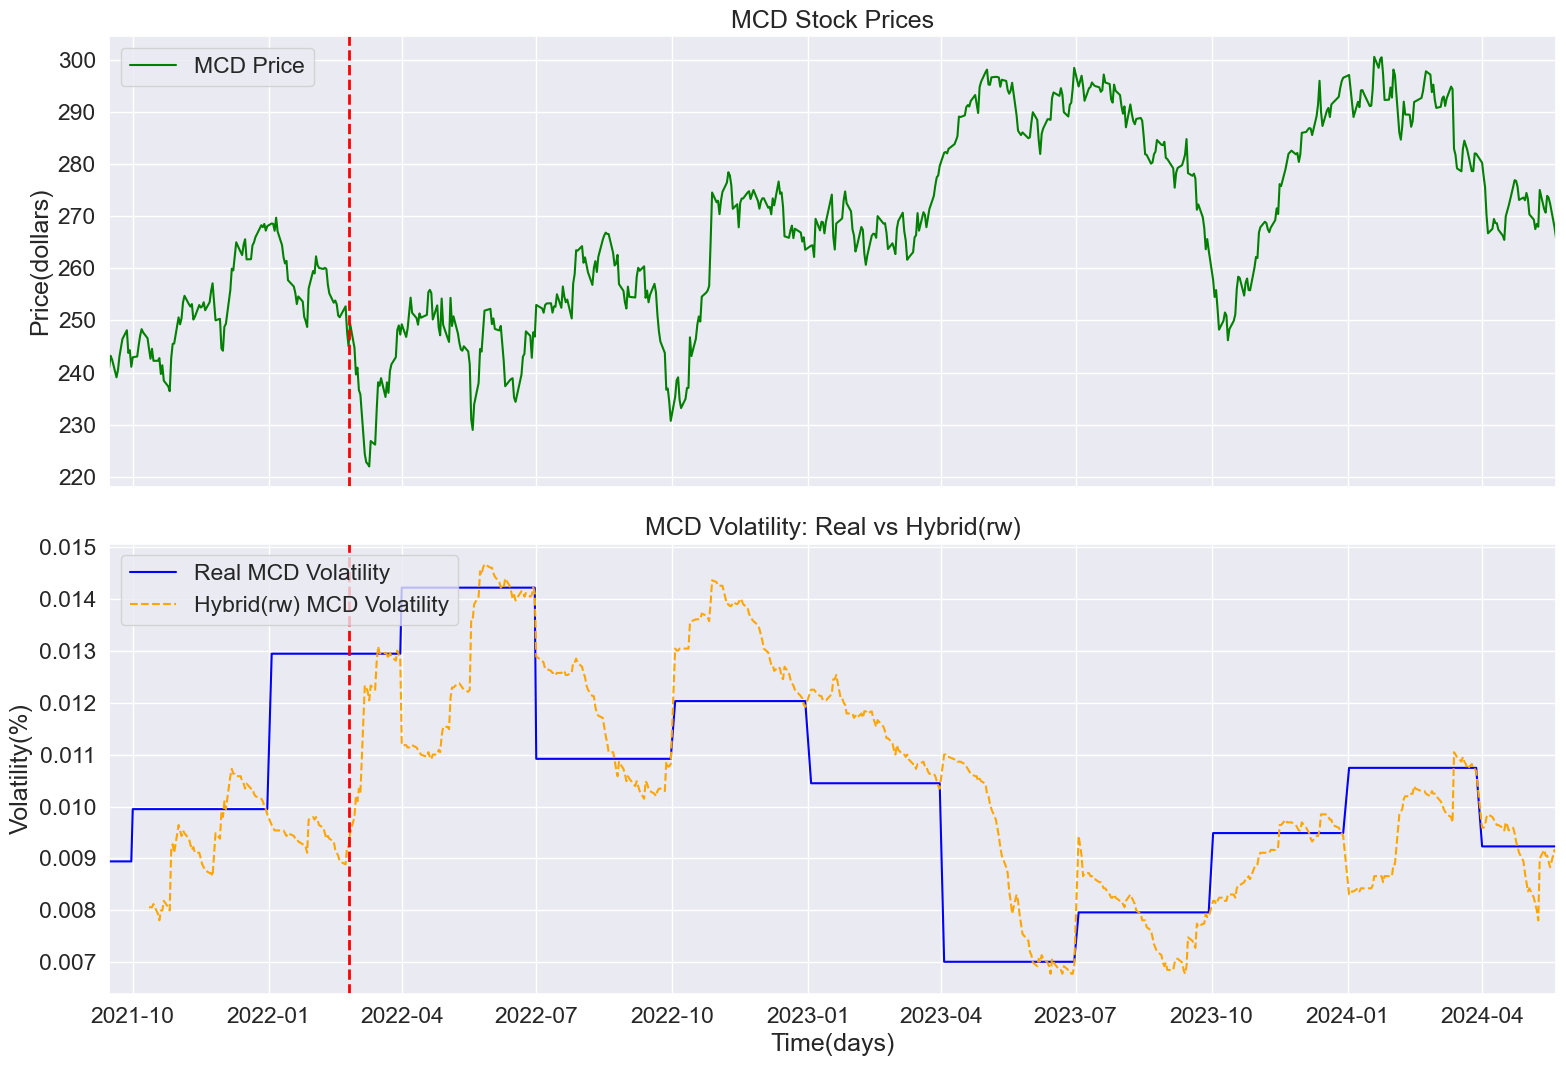

In [13]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "Hybrid(rw)")

lenght of the hybrid model dictionary: 656
lenght of the prescient dictionary: 3620
size of the first predictor: 656
size of the second predictor: 656
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


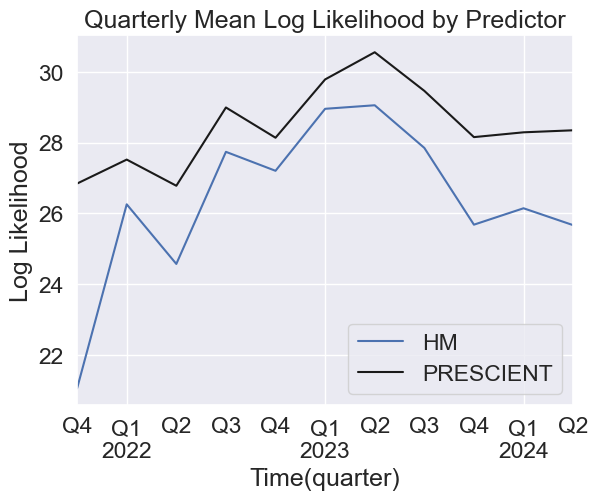

logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodHM: 26.400
stdLoglikelihoodHM: 2.200
maxLoglikelihoodHM: 29.100
logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodPRESCIENT: 28.400
stdLoglikelihoodPRESCIENT: 1.100
maxLoglikelihoodPRESCIENT: 30.600


meanRegret: 2.100
stdRegret: 1.300
maxRegret: 5.800
lenght of prescientDict:  3620
lenght of hybridDict:  656
lenght of predictorDict:  656

HM RMSE
mean: 0.0196366210
std: 0.0036238736
max: 0.0285553390
lenght of rmses:  11
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.02363724139045993, Timestamp('2022-03-31 00:00:00'): 0.01955379517386432, Timestamp('2022-06-30 00:00:00'): 0.02855533901655844, Timestamp('2022-10-02 00:00:00'): 0.017913089565693218, Timestamp('2023-01-02 00:00:00'): 0.01725066053020245, Timestamp('2023-04-02 00:00:00'): 0.021000715140620546, Timestamp('2023-07-02 00:00:00'): 0.020773553461269845, Timestamp('2023-10-01 00:00:00'): 0.017531191259201228, Timestamp('2024

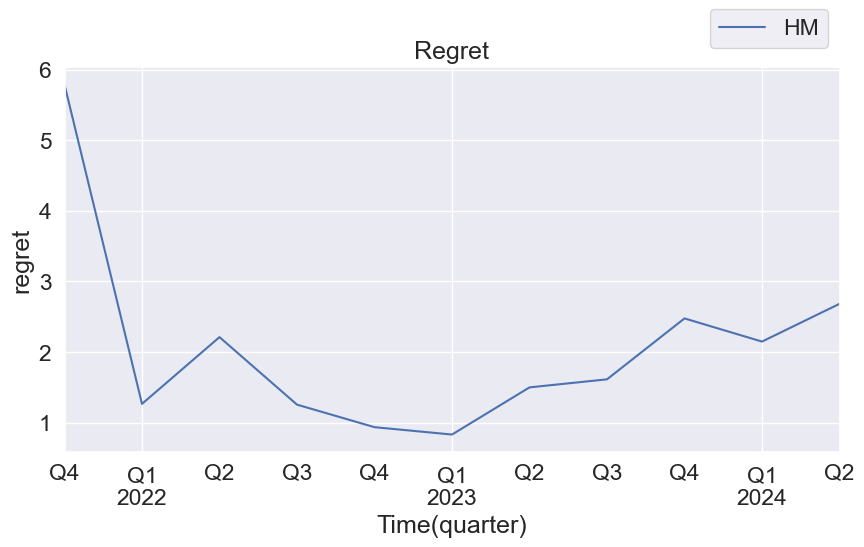

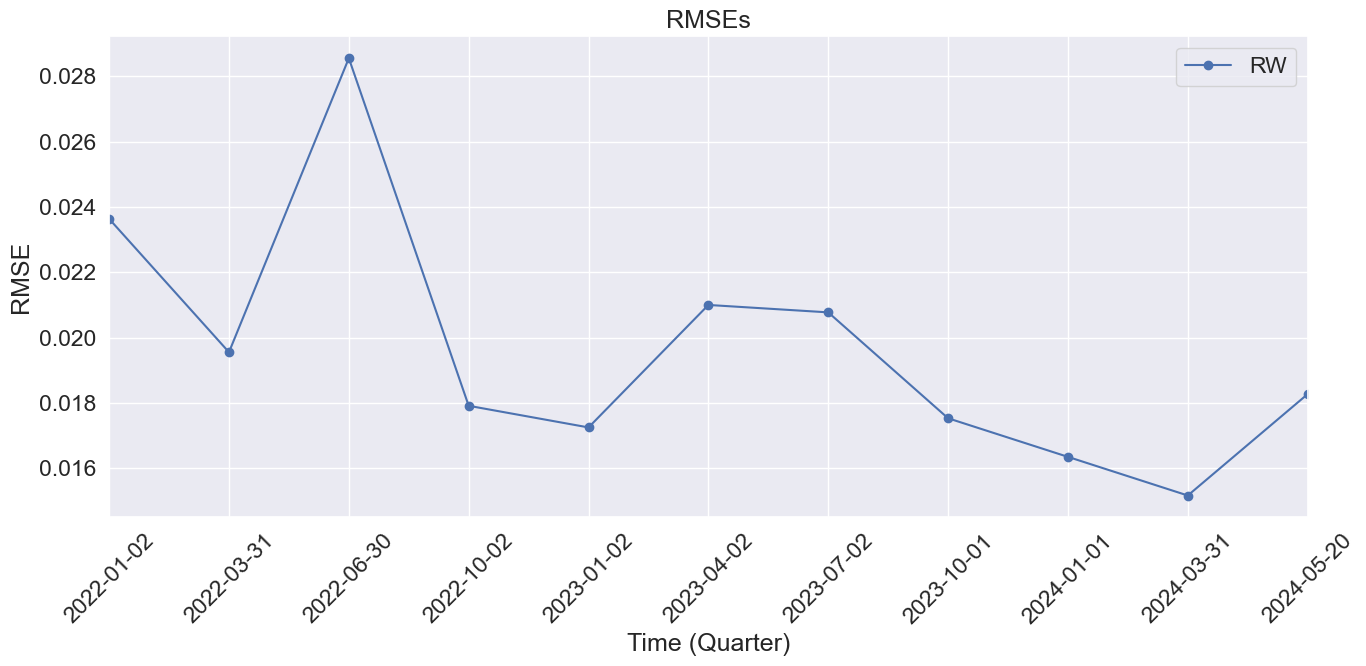

lenght of volatility_dict_aapl:  656
lenght of volatility_dict_aaapl_hybrid:  656
lenght of RMSEs_aapl:  11
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.0027964495708673242, Timestamp('2022-03-31 00:00:00'): 0.0024294224735481283, Timestamp('2022-06-30 00:00:00'): 0.005666734428083719, Timestamp('2022-10-02 00:00:00'): 0.0015440851653351023, Timestamp('2023-01-02 00:00:00'): 0.0022541661225400954, Timestamp('2023-04-02 00:00:00'): 0.004654796331881331, Timestamp('2023-07-02 00:00:00'): 0.005806165380756297, Timestamp('2023-10-01 00:00:00'): 0.001506574305850735, Timestamp('2024-01-01 00:00:00'): 0.001928079000563865, Timestamp('2024-03-31 00:00:00'): 0.0010483528977834058, Timestamp('2024-05-20 00:00:00'): 0.0027745952672249075}


RMSEs for AAPL
mean: 0.0029463110
std: 0.0015947270
max: 0.0058061654


RMSEs for IBM
mean: 0.0019144503
std: 0.0010038042
max: 0.0041762817


RMSEs for MCD
mean: 0.0013950589
std: 0.0007187787
max: 0.0028838227
Stored 'hybridRwDictFiltered' (d

In [14]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

print("lenght of the hybrid model dictionary: " + str(len(hybridModelDict)))
print("lenght of the prescient dictionary: " + str(len(prescientDict)))

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        hybrid: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(testDataWithPercentageChange, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        hybrid: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''

predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_filtered = {k: v for k, v in volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_filtered = {k: v for k, v in volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_filtered = {k: v for k, v in volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_filtered = {k: v for k, v in volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_filtered = {k: v for k, v in volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_filtered = {k: v for k, v in volatility_dict_wmt.items() if k >= startDAte}


volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_wmt.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

hybridRwDictFiltered = predictors[0]
%store hybridRwDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [15]:
#volatility_dict_aapl_hybrid_filtered
hybrid_rw_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_rw_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_rw_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_rw_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

if numberOfAssets == 6:
    hybrid_rw_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_rw_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_rw_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered

if numberOfAssets == 9:
    hybrid_rw_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_rw_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_rw_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered
    hybrid_rw_volatilities["ORCL"] = volatility_dict_orcl_hybrid_filtered
    hybrid_rw_volatilities["PFE"] = volatility_dict_pfe_hybrid_filtered
    hybrid_rw_volatilities["WMT"] = volatility_dict_wmt_hybrid_filtered

# store the dictionary
%store hybrid_rw_volatilities

Stored 'hybrid_rw_volatilities' (dict)


# Validation Phase for Hybrid Model predictor (EW + EWMA)

In [16]:
def hybridPredictorValidationPhaseWithEwma(betaValue, startingDate, endingDate, betaIncrement, prescientAlreadyPrinted, expandingWindowDict):
    '''
    this function is used to perform the validation phase of the hybrid predictor; it's used to find the best beta value for the EWMA predictor part of this hybrid model.
    Grid search is used and the performance of the beta hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while betaValue < 1:

        ewma_halflife = -np.log(2) / np.log(betaValue)
        
        # obtain the ewma covariance matrixes
        ewmaDict = dict(_ewma_cov(validationDataWithPercentageChange, halflife=ewma_halflife))

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
        
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        # filter the ewmaDict dictionary by the start and end date
        ewmaDict = {t: ewmaDict[t] for t in ewmaDict.keys() if t >= start_date and t <= end_date}

        # filter the expandingWindowDict dictionary by the start and end date
        expandingWindowDict = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

        # filter the stocksPercentageChangeReturn dataset by the start and end date
        filteredDataset = stocksPercentageChangeReturn.loc[start_date:end_date]
        
        # now i can get the hybrid predictor covariance matrixes, this because i have the ewma and prescient covariance matrixes filtered by the start and end date(validation period)
        hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, filteredDataset, expandingWindowDict, ewmaDict, start_date)

        names = ["HYBRID", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [hybridModelDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]
            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                hybridMeanRegretValues.append(regretMetrics[0])


        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":

                # save the loglikelihood mean values to plot a chart
                hybridMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]

        # save every fundamental value to plot a chart 
        betaValues.append(betaValue)

        # Increment beta
        betaValue += betaIncrement

    print("dimension of hybridDict: " + str(len(hybridModelDict)))
    print("first timestamp of hybridDict: " + str(list(hybridModelDict.keys())[0]))
    print("last timestamp of hybridDict: " + str(list(hybridModelDict.keys())[-1]))

    # return the fundamental values to plot a chart
    return betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

In [17]:
'''
# first run for grid search -> this is a general run to cover the entire range of beta values

# clear the lists to make another run of the grid search
betaValues.clear()
hybridMeanRegretValues.clear()
hybridMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted, expandingWindowDict)

plotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")
'''

'\n# first run for grid search -> this is a general run to cover the entire range of beta values\n\n# clear the lists to make another run of the grid search\nbetaValues.clear()\nhybridMeanRegretValues.clear()\nhybridMeanlogLikelihoodValues.clear()\nprescientMeanlogLikelihoodValue = 0\n\nbetaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted, expandingWindowDict)\n\nplotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")\n'

In [18]:
# skip validation phase, i already knew the best beta value
# clear the lists to make another run of the grid search
'''
betaValues.clear()
hybridMeanRegretValues.clear()
hybridMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)
betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted, expandingWindowDict)

plotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")
'''

'\nbetaValues.clear()\nhybridMeanRegretValues.clear()\nhybridMeanlogLikelihoodValues.clear()\nprescientMeanlogLikelihoodValue = 0\n\n# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)\nbetaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted, expandingWindowDict)\n\nplotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")\n'

# Test Phase for Hybrid predictor (EW + EWMA)

In [19]:
# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset
start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = predictorsConfiguration["HYBRIDEWMA_beta"]
ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(testDataWithPercentageChange, ewma_halflife))

# filter the ewmaDict dictionary by the start and end date
ewmaDict = {t: ewmaDict[t] for t in ewmaDict.keys() if t >= start_date and t <= end_date}

print("dimension of the ewma dictionary: " + str(len(ewmaDict)))


ewma_halflife used: 17.424133266908527

dimension of the ewma dictionary: 675


In [20]:
# HYBRID MODEL IMPLEMENTATION
# i have defined inside the 2 box above the expanding window and the ewma predictors; now i will use them to implement the hybrid model

# the hybrid model is a combination of the expanding window and the ewma predictors; the lambda parameter is incremented linearly in each quarter. so it is like the inverse of the number of days in a quarter

hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDict, ewmaDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])    

dimension of the hybrid model dictionary: 675
first 3 elements of the hybrid model dictionary: 
2021-09-15 00:00:00           7         20990     21177     20468     21384     21018     8045   \
7      0.000039  0.000044 -0.000003  0.000021  0.000034  0.000023  0.000095   
20990  0.000044  0.000052 -0.000004  0.000025  0.000040  0.000027  0.000111   
21177 -0.000003 -0.000004  0.000001 -0.000002 -0.000003 -0.000002 -0.000009   
20468  0.000021  0.000025 -0.000002  0.000012  0.000019  0.000013  0.000053   
21384  0.000034  0.000040 -0.000003  0.000019  0.000032  0.000021  0.000087   
21018  0.000023  0.000027 -0.000002  0.000013  0.000021  0.000014  0.000058   
8045   0.000095  0.000111 -0.000009  0.000053  0.000087  0.000058  0.000240   
21394  0.000009  0.000010 -0.000001  0.000005  0.000008  0.000005  0.000021   
21880  0.000011  0.000012 -0.000001  0.000006  0.000010  0.000007  0.000027   

          21394     21880  
7      0.000009  0.000011  
20990  0.000010  0.000012  
21177 -0.

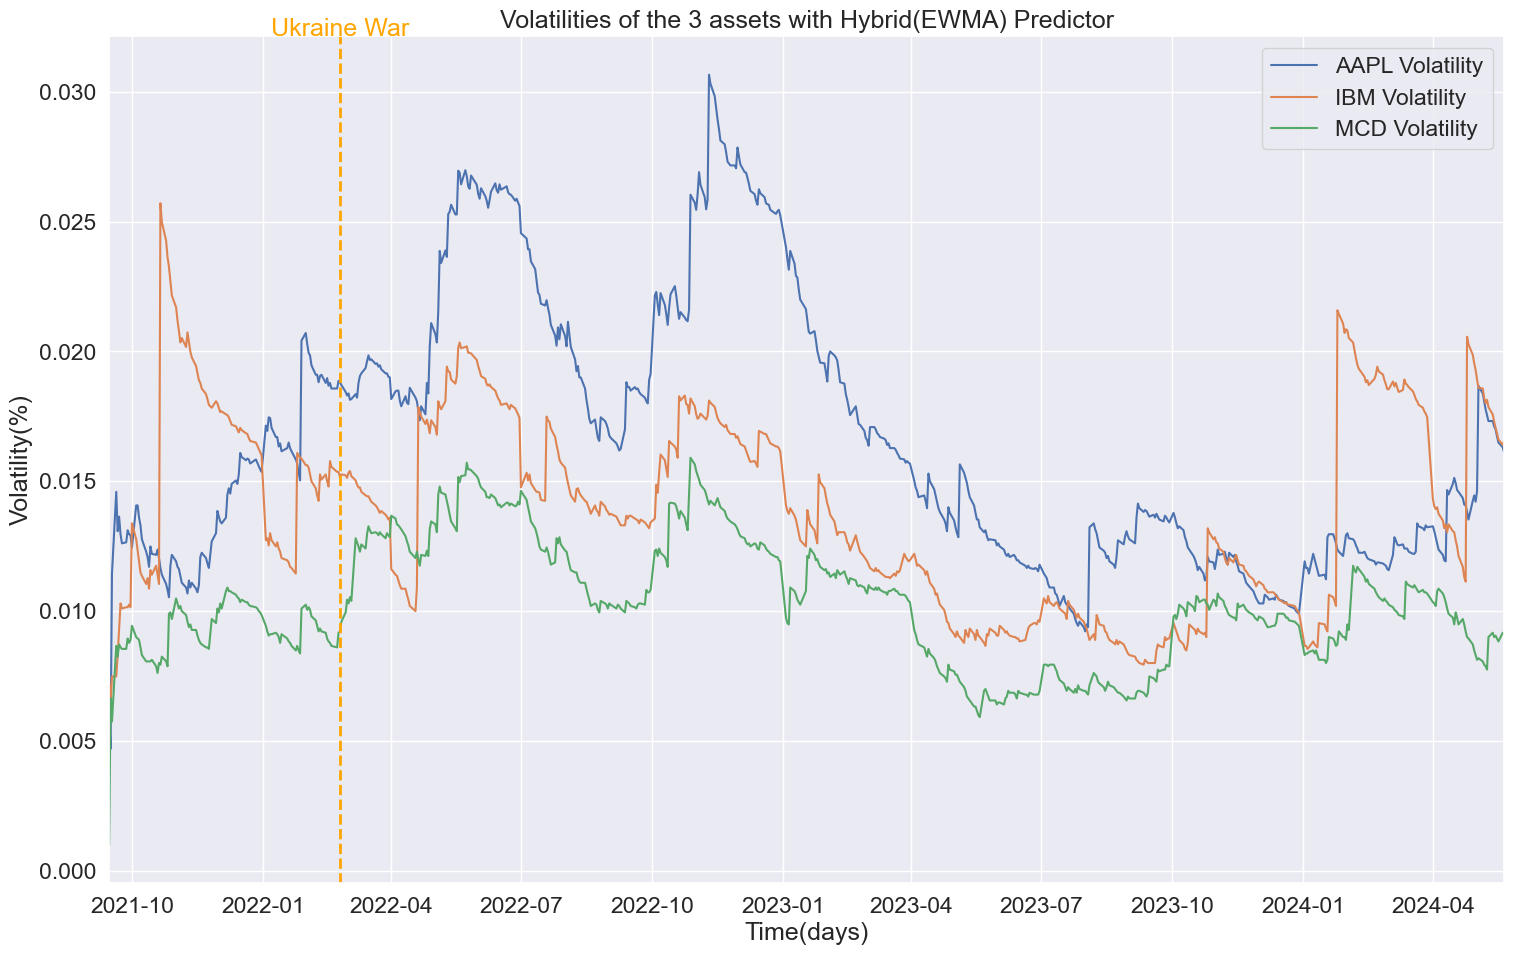

In [21]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# assets names are AAPL, IBM, MCD, KO, PEP, JNJ, ORCL, PFE, WMT
df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd,  df_hybrid_volatility_ko, df_hybrid_volatility_pep, df_hybrid_volatility_jnj, df_hybrid_volatility_orcl, df_hybrid_volatility_pfe, df_hybrid_volatility_wmt, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd, hybrid_volatility_dict_ko, hybrid_volatility_dict_pep, hybrid_volatility_dict_jnj, hybrid_volatility_dict_orcl, hybrid_volatility_dict_pfe, hybrid_volatility_dict_wmt = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(EWMA)')

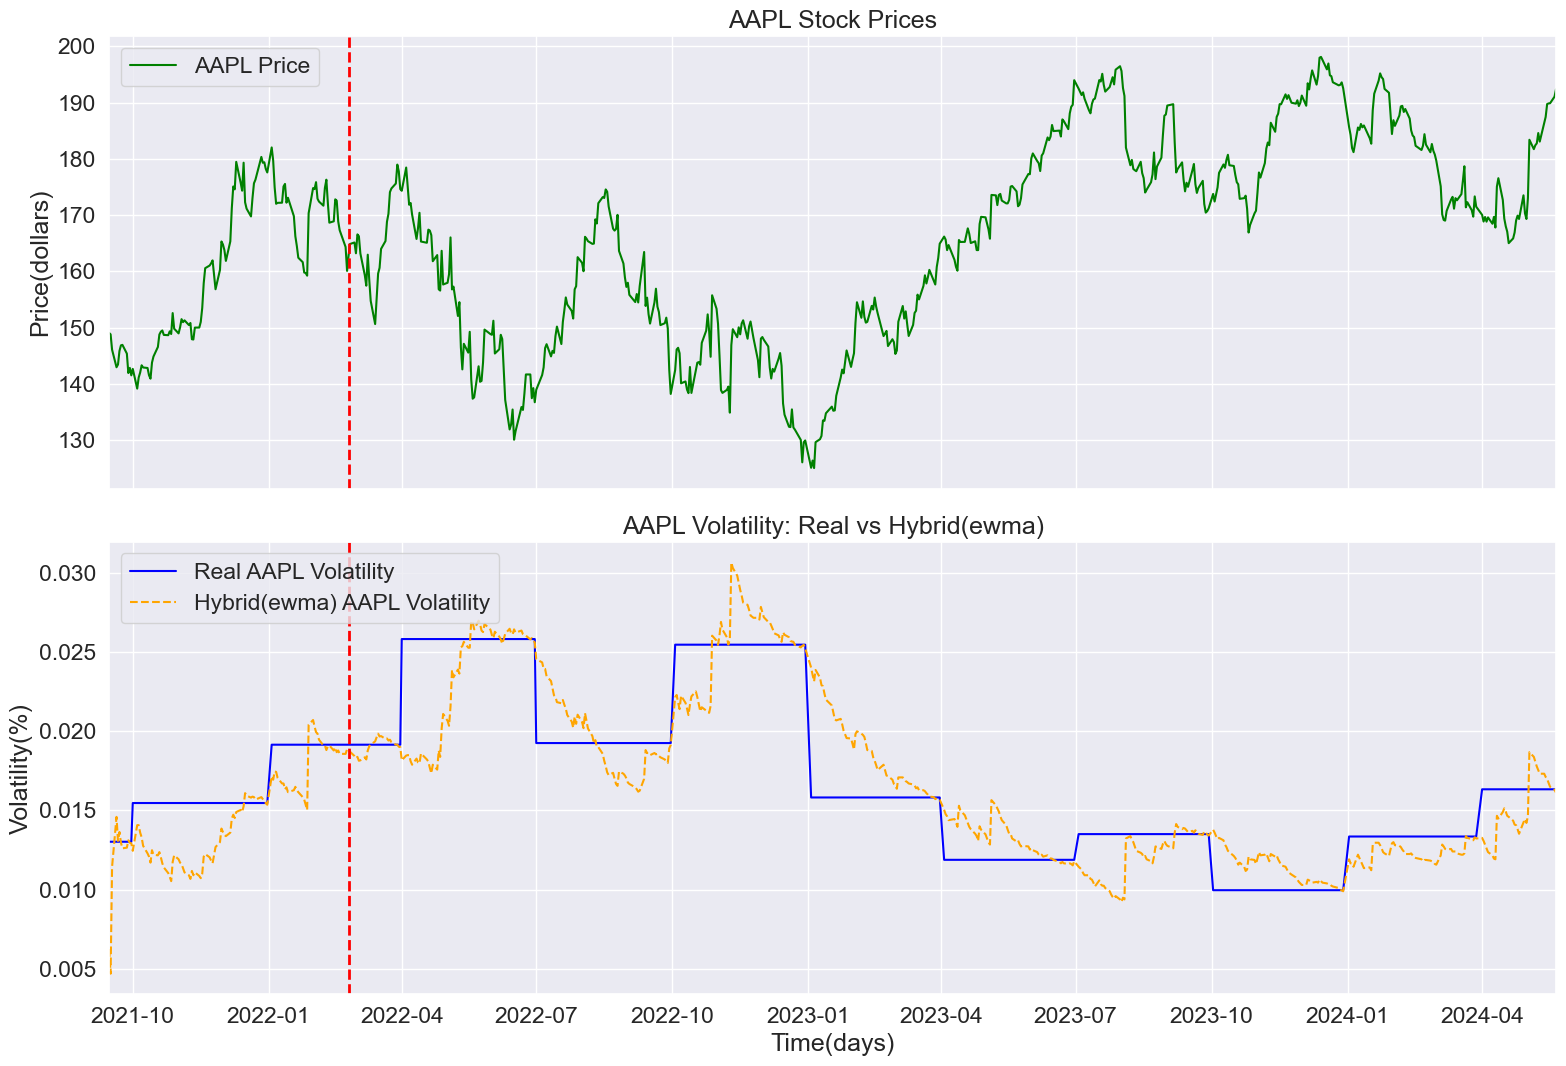

In [22]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "Hybrid(ewma)")

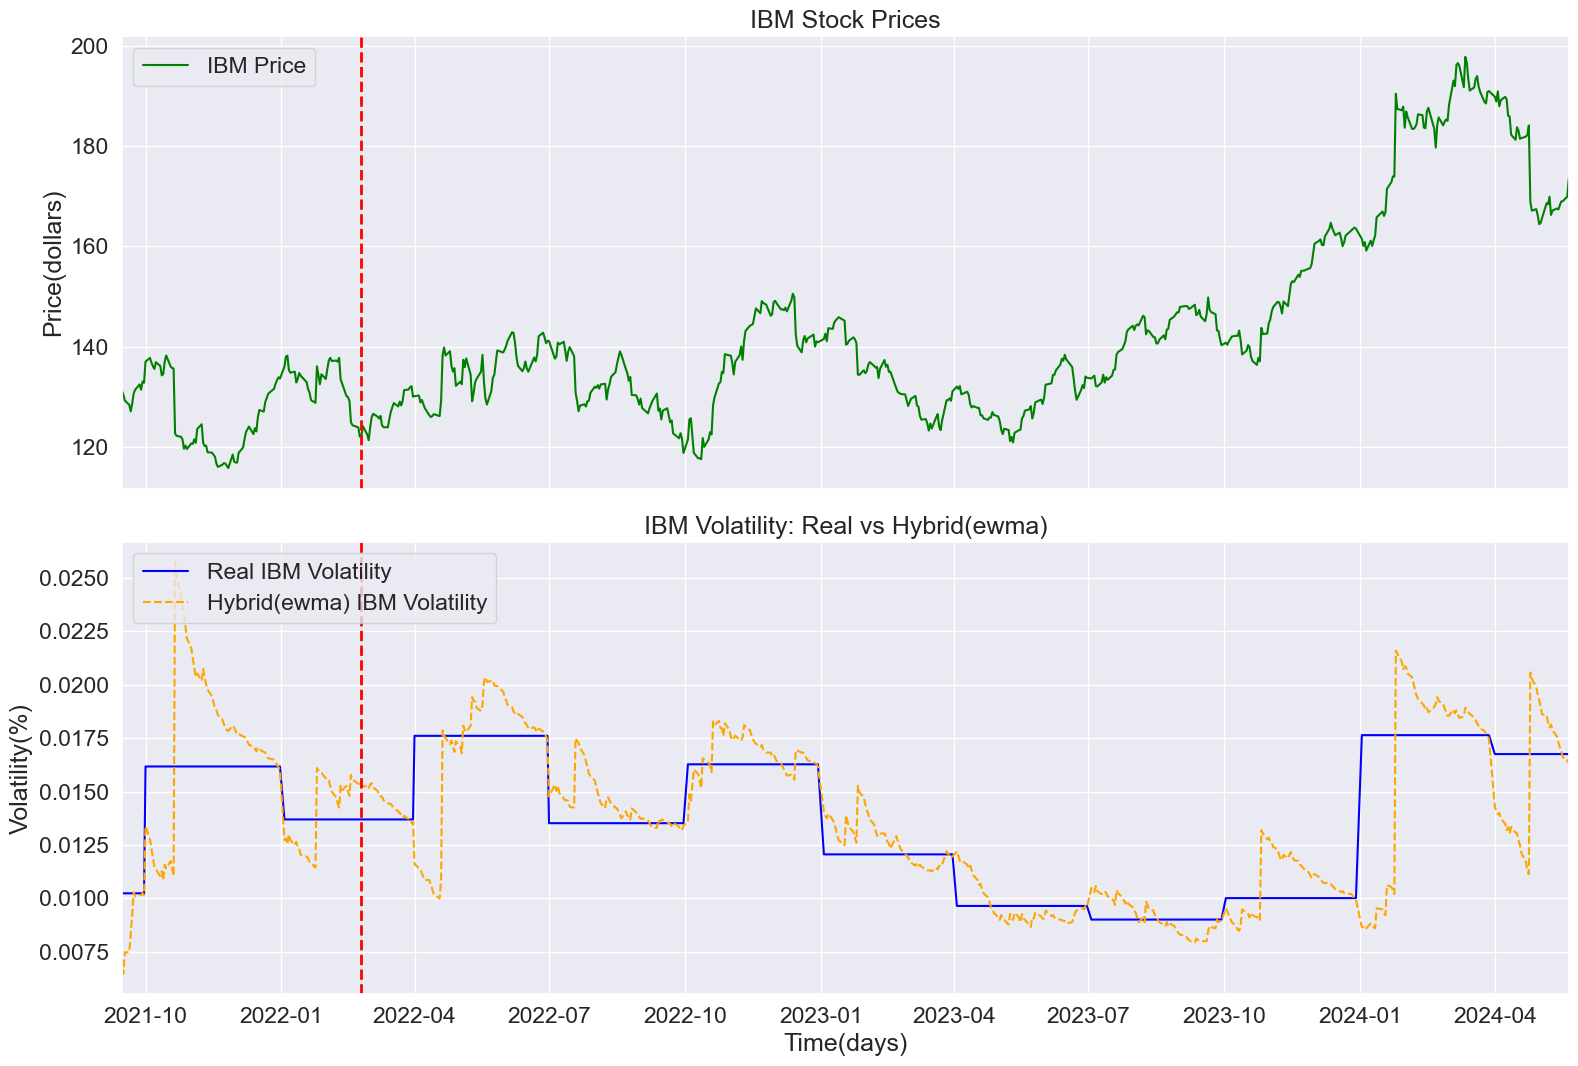

In [23]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "Hybrid(ewma)")

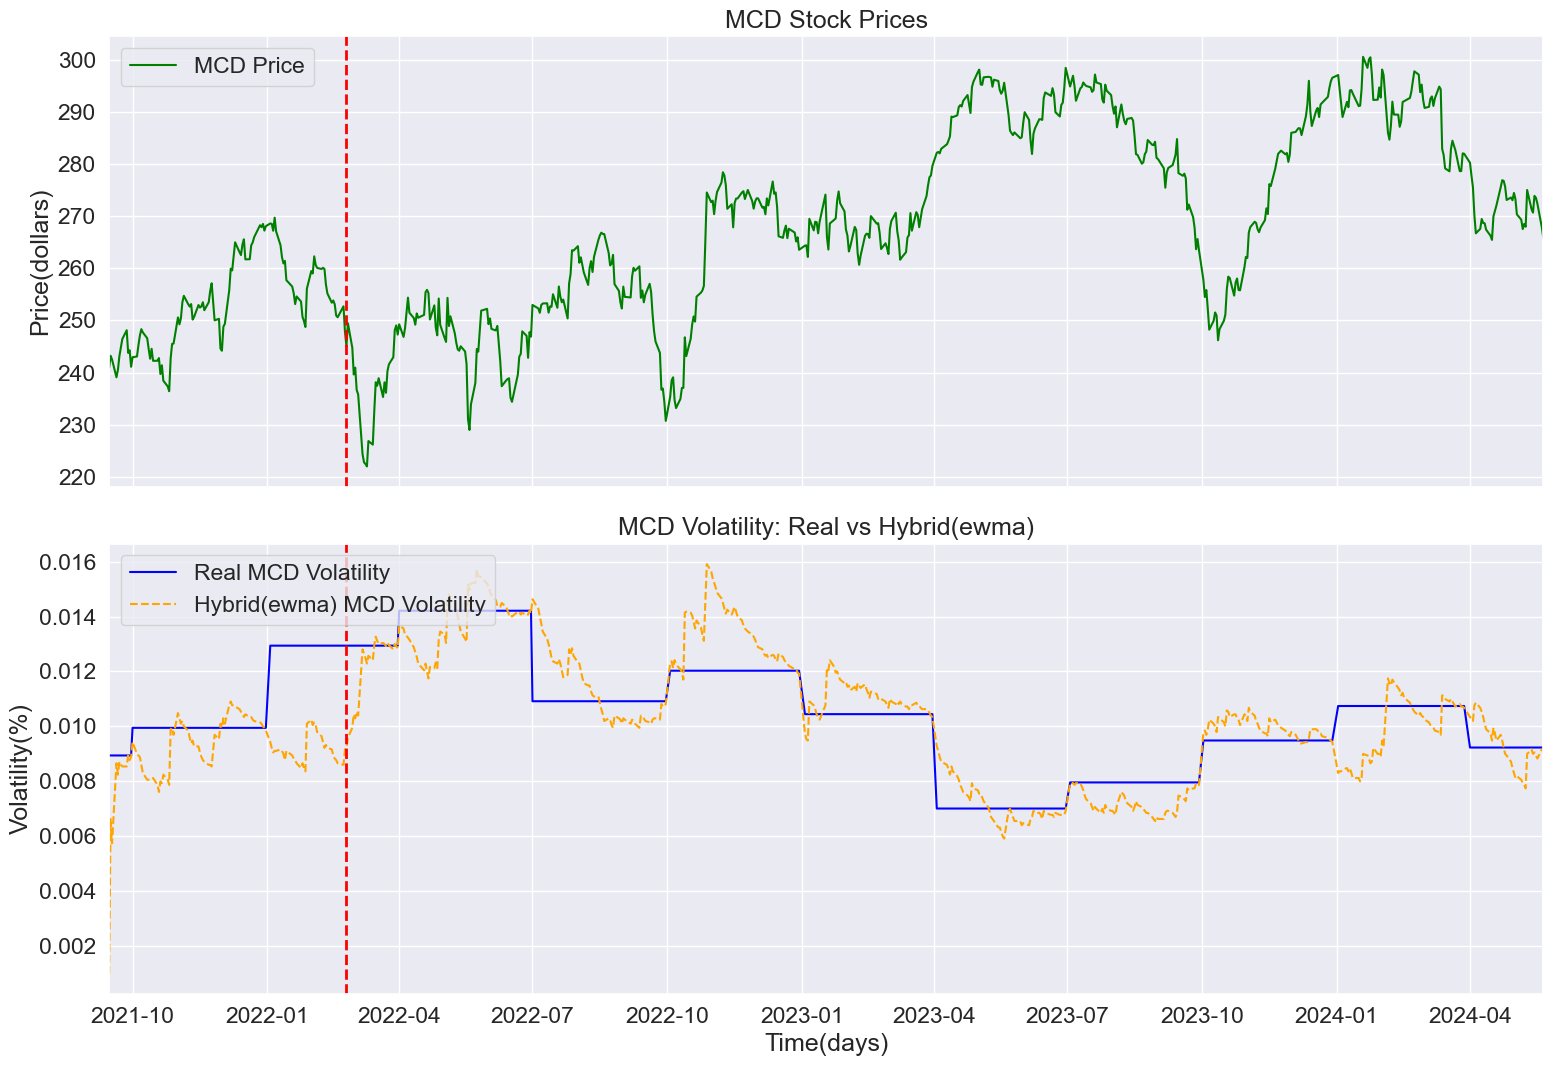

In [24]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "Hybrid(ewma)")

size of the first predictor: 656
size of the second predictor: 656
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


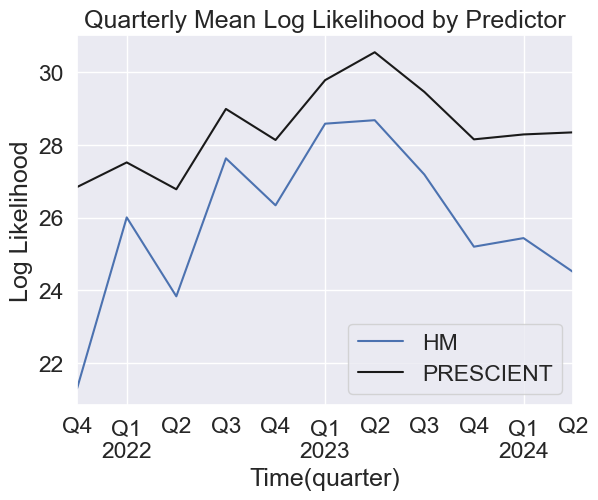

logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodHM: 25.900
stdLoglikelihoodHM: 2.100
maxLoglikelihoodHM: 28.700
logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodPRESCIENT: 28.400
stdLoglikelihoodPRESCIENT: 1.100
maxLoglikelihoodPRESCIENT: 30.600


meanRegret: 2.600
stdRegret: 1.200
maxRegret: 5.500
lenght of prescientDict:  3620
lenght of hybridDict:  675
lenght of predictorDict:  656

HM RMSE
mean: 0.0189677475
std: 0.0033870825
max: 0.0265383049
lenght of rmses:  11
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.024016876508730967, Timestamp('2022-03-31 00:00:00'): 0.020768045326088256, Timestamp('2022-06-30 00:00:00'): 0.026538304874496488, Timestamp('2022-10-02 00:00:00'): 0.019520578944538434, Timestamp('2023-01-02 00:00:00'): 0.01820432626122413, Timestamp('2023-04-02 00:00:00'): 0.01680547407273856, Timestamp('2023-07-02 00:00:00'): 0.01506119525260565, Timestamp('2023-10-01 00:00:00'): 0.016866785647686455, Timestamp('202

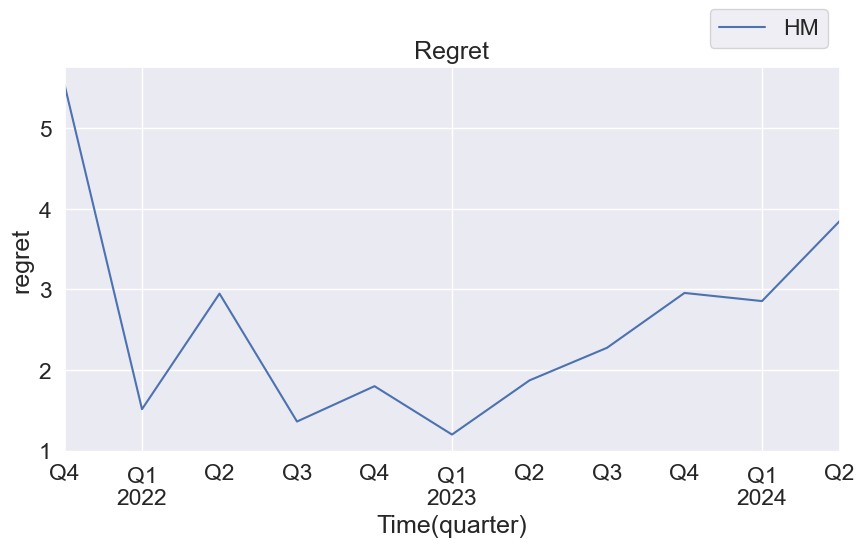

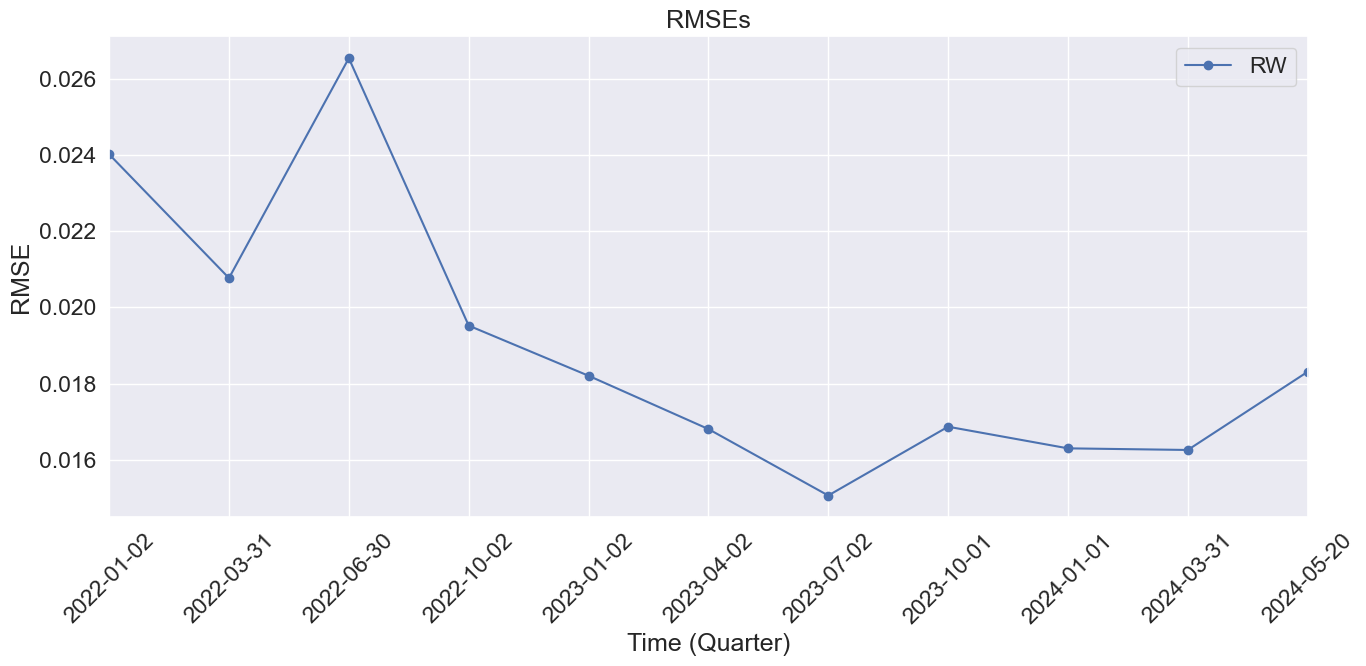

lenght of volatility_dict_aapl:  656
lenght of volatility_dict_aaapl_hybrid:  656
lenght of RMSEs_aapl:  11
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.0029049563030916522, Timestamp('2022-03-31 00:00:00'): 0.0015951175713371814, Timestamp('2022-06-30 00:00:00'): 0.004442266348013781, Timestamp('2022-10-02 00:00:00'): 0.0022566227578024885, Timestamp('2023-01-02 00:00:00'): 0.002625076350783627, Timestamp('2023-04-02 00:00:00'): 0.0037573092574193726, Timestamp('2023-07-02 00:00:00'): 0.0018098246963635866, Timestamp('2023-10-01 00:00:00'): 0.002132157848517477, Timestamp('2024-01-01 00:00:00'): 0.0018021736160818151, Timestamp('2024-03-31 00:00:00'): 0.0011728151217241423, Timestamp('2024-05-20 00:00:00'): 0.002316612103963389}


RMSEs for AAPL
mean: 0.0024377211
std: 0.0009176007
max: 0.0044422663


RMSEs for IBM
mean: 0.0020635039
std: 0.0012377651
max: 0.0045546482


RMSEs for MCD
mean: 0.0012198158
std: 0.0006569717
max: 0.0030707942
Stored 'hybridEwmaDictFiltered'

In [25]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDict = predictors[0]
hybridDict = {k: hybridDict[k] for k in list(hybridDict)[19:]}
predictors[0] = hybridDict

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(testDataWithPercentageChange, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_filtered = {k: v for k, v in volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_filtered = {k: v for k, v in volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_filtered = {k: v for k, v in volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_filtered = {k: v for k, v in volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_filtered = {k: v for k, v in volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_filtered = {k: v for k, v in volatility_dict_wmt.items() if k >= startDAte}

volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_wmt.items() if k >= startDAte}

print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))

# get the rmse of single assets. i take just aapl, ibm and mcd
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

# store the covariance matrixes dict of the filtered dataset
hybridEwmaDictFiltered = predictors[0]

# store the covariance matrixes dict of the filtered dataset(just for the hibryd mgarch)
%store hybridEwmaDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [26]:
# create a dictionary for the volatilities of the prescient predictor
hybrid_ewma_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_ewma_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_ewma_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_ewma_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

if numberOfAssets == 6:
    hybrid_ewma_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_ewma_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_ewma_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered

if numberOfAssets == 9:
    hybrid_ewma_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_ewma_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_ewma_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered
    hybrid_ewma_volatilities["ORCL"] = volatility_dict_orcl_hybrid_filtered
    hybrid_ewma_volatilities["PFE"] = volatility_dict_pfe_hybrid_filtered
    hybrid_ewma_volatilities["WMT"] = volatility_dict_wmt_hybrid_filtered

# store the dictionary
%store hybrid_ewma_volatilities

Stored 'hybrid_ewma_volatilities' (dict)


# Validation Phase for Hybrid predictor (EW + MGARCH)

In [27]:
def modify_env_variable(env_file_path, variable_to_modify, new_value):
    '''
    code to modify the value of a specific variable in a .env file
    '''
    # Read the .env file
    with open(env_file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the specific variable
    modified_lines = []
    variable_found = False
    for line in lines:
        if line.startswith(variable_to_modify):
            modified_lines.append(f"{variable_to_modify}={new_value}\n")
            variable_found = True
        else:
            modified_lines.append(line)
    
    # If the variable was not found, add it to the file
    if not variable_found:
        modified_lines.append(f"{variable_to_modify}={new_value}\n")
    
    # Write the modified content back to the .env file
    with open(env_file_path, 'w') as file:
        file.writelines(modified_lines)

In [28]:
from mgarchAnalysis.flattenCovMatrices import *

def callRprocessAndUpdateCSVfile(csv_file_path, r_file_path):
    '''
    Function to call the R process and update the csv validation file
    '''

    # modify the environment variable USE_HYBRID_MGARCH to true
    modify_env_variable(file_path_first_part + 'experiments/.env', 'USE_HYBRID_MGARCH', 'true')

    csv_file_path = file_path_first_part + csv_file_path
    # Define the path to your R script
    r_script_path = file_path_first_part + r_file_path 

    # Define the command to run your R script
    command = ['Rscript', r_script_path]

    returnCode = 1

    while returnCode != 0:
        
        # Execute the command
        result = subprocess.run(command, capture_output=True, text=True)
        # if the code fails there is a problem of convergence so i keep trying to run the R script until it converges
        # Check if there was an error and raise an exception if so
        if result.returncode != 0:
            print("Error running the R script:")
            print(result.stderr)
        else:
            # If no error, print the output
            print("R script executed successfully:")
            print(result.stdout)
            returnCode = 0

    # Update the csv file with the validation results
    flattenAllMatrices(csv_file_path)

In [29]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions
'''
callRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", 'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r')

# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print
'''

'\ncallRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", \'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r\')\n\n# The covariance matrices were computed for 100*r for numerical reasons \n\nmgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)\n\n# here we are obtaining the covariance matrix calculated for every day from the csv file;\n# so this covariance matrix estimation is done with real returns and not with interpolated returns\nSigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio\n\nprint("sigma shape:", Sigmas.shape)\n# Remove the training dataset \ntrainingSetLength = len(trainingDataWithPercentageChange)\ntestSetLength = len(testDataWithPercentageChange)\ntimes = stocksPercentageChangeReturn.loc[validat

In [30]:
# now see how well the mgarch predictor is doing in predicting the real volatilities of the 3 assets by calculating the log-likelihood and the regret and mse

start_date = pd.to_datetime(startingValidationDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingValidationDate, format="%Y-%m-%d")

In [31]:
# now i get the covariance matrixes of the hybrid predictor using expanding window and mgarch
'''
hybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, validationDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])
'''

'\nhybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, validationDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)\n\nprint("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))\n\nprint("first 3 elements of the hybrid model dictionary: ")\nfor key in list(hybridModelDict.keys())[:3]:\n    print(key, hybridModelDict[key])\n'

In [32]:
'''
names = ["HYBRID", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# metrics to evaluate during the validation period: log-likelihood, regret, and MSE
'''
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''
'''
print("length of hybrid predictor: ", len(predictors[0]))
print("length of prescient predictor: ", len(predictors[1]))

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


daily_log_likelihoods = predictorLogLikelihood(stocksPercentageChangeReturn, predictors, names)
'''

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
'''
predictorRegret(daily_log_likelihoods, names)
'''

'\npredictorRegret(daily_log_likelihoods, names)\n'

In [33]:
'''
startingValidationDate = validationDataWithPrices.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPrices.index[-1].strftime("%Y-%m-%d")

# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingValidationDate)
real_volatility_endDate = pd.to_datetime(endingValidationDate)

df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(MGARCH)')
'''

'\nstartingValidationDate = validationDataWithPrices.index[0].strftime("%Y-%m-%d")\nendingValidationDate = validationDataWithPrices.index[-1].strftime("%Y-%m-%d")\n\n# now filter the rw volatilities between the start and end date\nreal_volatility_startDate = pd.to_datetime(startingValidationDate)\nreal_volatility_endDate = pd.to_datetime(endingValidationDate)\n\ndf_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, \'Hybrid(MGARCH)\')\n'

In [34]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

#plot_prices_volatilities_for_predictor(validationDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_hybrid['AAPL Volatility'], 'AAPL', "hybrid(mgarch)")

# Test Phase for Hybrid predictor (EW + MGARCH)

In [35]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions

callRprocessAndUpdateCSVfile("AllCovMatricesForTesting.csv", "experiments/mgarchAnalysis/dccGarchTrainValidationTest.r")

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForTesting.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
validationSetLength = len(validationDataWithPercentageChange)
times = stocksPercentageChangeReturn.index[trainingSetLength + validationSetLength:]

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

R script executed successfully:
[1] "TRAIN AND TEST RUN"

Model order: 3 
Training data size: 2291 
Validation data size: 654 
Testing data size: 675 
Length  Class   Mode 
     1 DCCfit     S4 

*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(3,3)
No. Parameters       :  114
[VAR GARCH DCC UncQ] : [0+72+6+36]
No. Series           :  9
No. Obs.             :  2290
Log-Likelihood       :  66896.42
Av.Log-Likelihood    :  29.21 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error   t value Pr(>|t|)
[AAPL].mu      0.001326    0.000350  3.786500 0.000153
[AAPL].omega   0.000035    0.000020  1.754085 0.079416
[AAPL].alpha1  0.152199    0.051126  2.976930 0.002912
[AAPL].alpha2  0.031856    0.038685  0.823477 0.410237
[AAPL].alpha3  0.008727    0.085681  0.101858 0.918870
[AAPL].beta1   0.000079    0.222800  0.000353 0.999718
[AAPL].b

In [36]:
# calculate the hybrid predictor covariance matrix for the test phase

hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

# print the first and the last element of the dictionary
print(list(hybridModelDict.keys())[0]) # TODO: delete this print
print(hybridModelDict[list(hybridModelDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(hybridModelDict.keys())[-1]) # TODO: delete this print
print(hybridModelDict[list(hybridModelDict.keys())[-1]]) # TODO: delete this print

dimension of the hybrid model dictionary: 675
2021-09-15 00:00:00
          7         20990     21177     20468     21384     21018     8045   \
7      0.000302  0.000055  0.000046  0.000041  0.000046  0.000046  0.000087   
20990  0.000055  0.000131  0.000033  0.000040  0.000032  0.000038  0.000071   
21177  0.000046  0.000033  0.000069  0.000034  0.000029  0.000028  0.000036   
20468  0.000041  0.000040  0.000034  0.000075  0.000047  0.000038  0.000043   
21384  0.000046  0.000032  0.000029  0.000047  0.000067  0.000038  0.000038   
21018  0.000046  0.000038  0.000028  0.000038  0.000038  0.000090  0.000048   
8045   0.000087  0.000071  0.000036  0.000043  0.000038  0.000048  0.000197   
21394  0.000051  0.000047  0.000023  0.000037  0.000033  0.000058  0.000053   
21880  0.000041  0.000028  0.000024  0.000029  0.000033  0.000032  0.000034   

          21394     21880  
7      0.000051  0.000041  
20990  0.000047  0.000028  
21177  0.000023  0.000024  
20468  0.000037  0.000029  
213

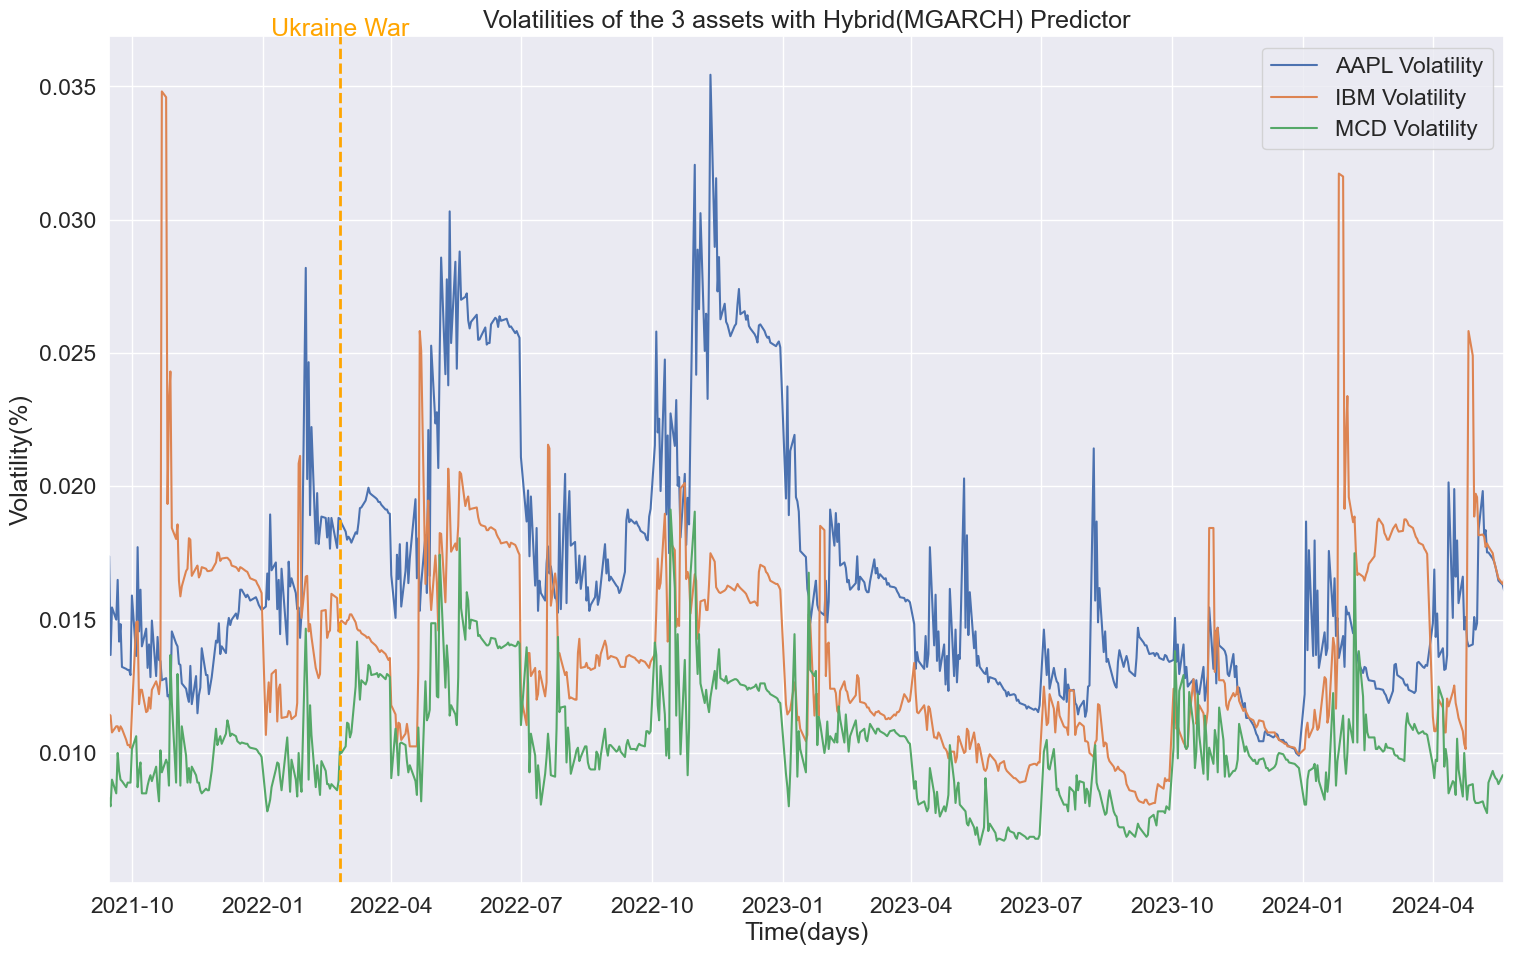

In [37]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# assets names are AAPL, IBM, MCD, KO, PEP, JNJ, ORCL, PFE, WMT
df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd,  df_hybrid_volatility_ko, df_hybrid_volatility_pep, df_hybrid_volatility_jnj, df_hybrid_volatility_orcl, df_hybrid_volatility_pfe, df_hybrid_volatility_wmt, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd, hybrid_volatility_dict_ko, hybrid_volatility_dict_pep, hybrid_volatility_dict_jnj, hybrid_volatility_dict_orcl, hybrid_volatility_dict_pfe, hybrid_volatility_dict_wmt = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(MGARCH)')

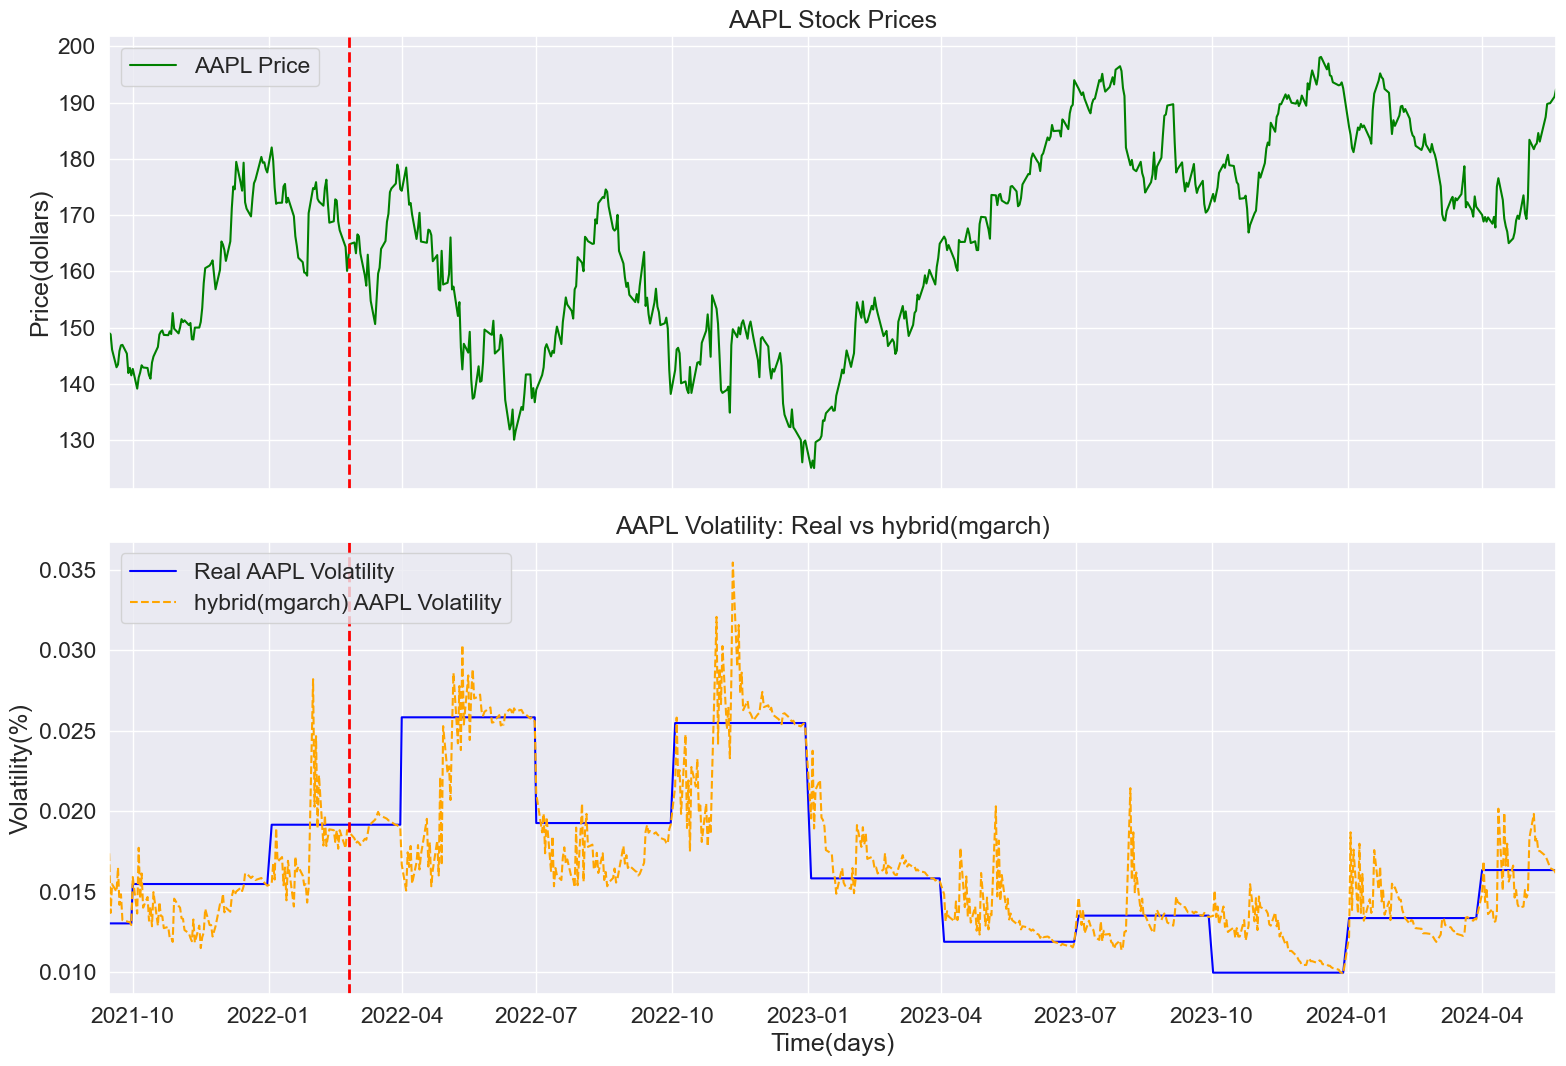

In [38]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "hybrid(mgarch)")

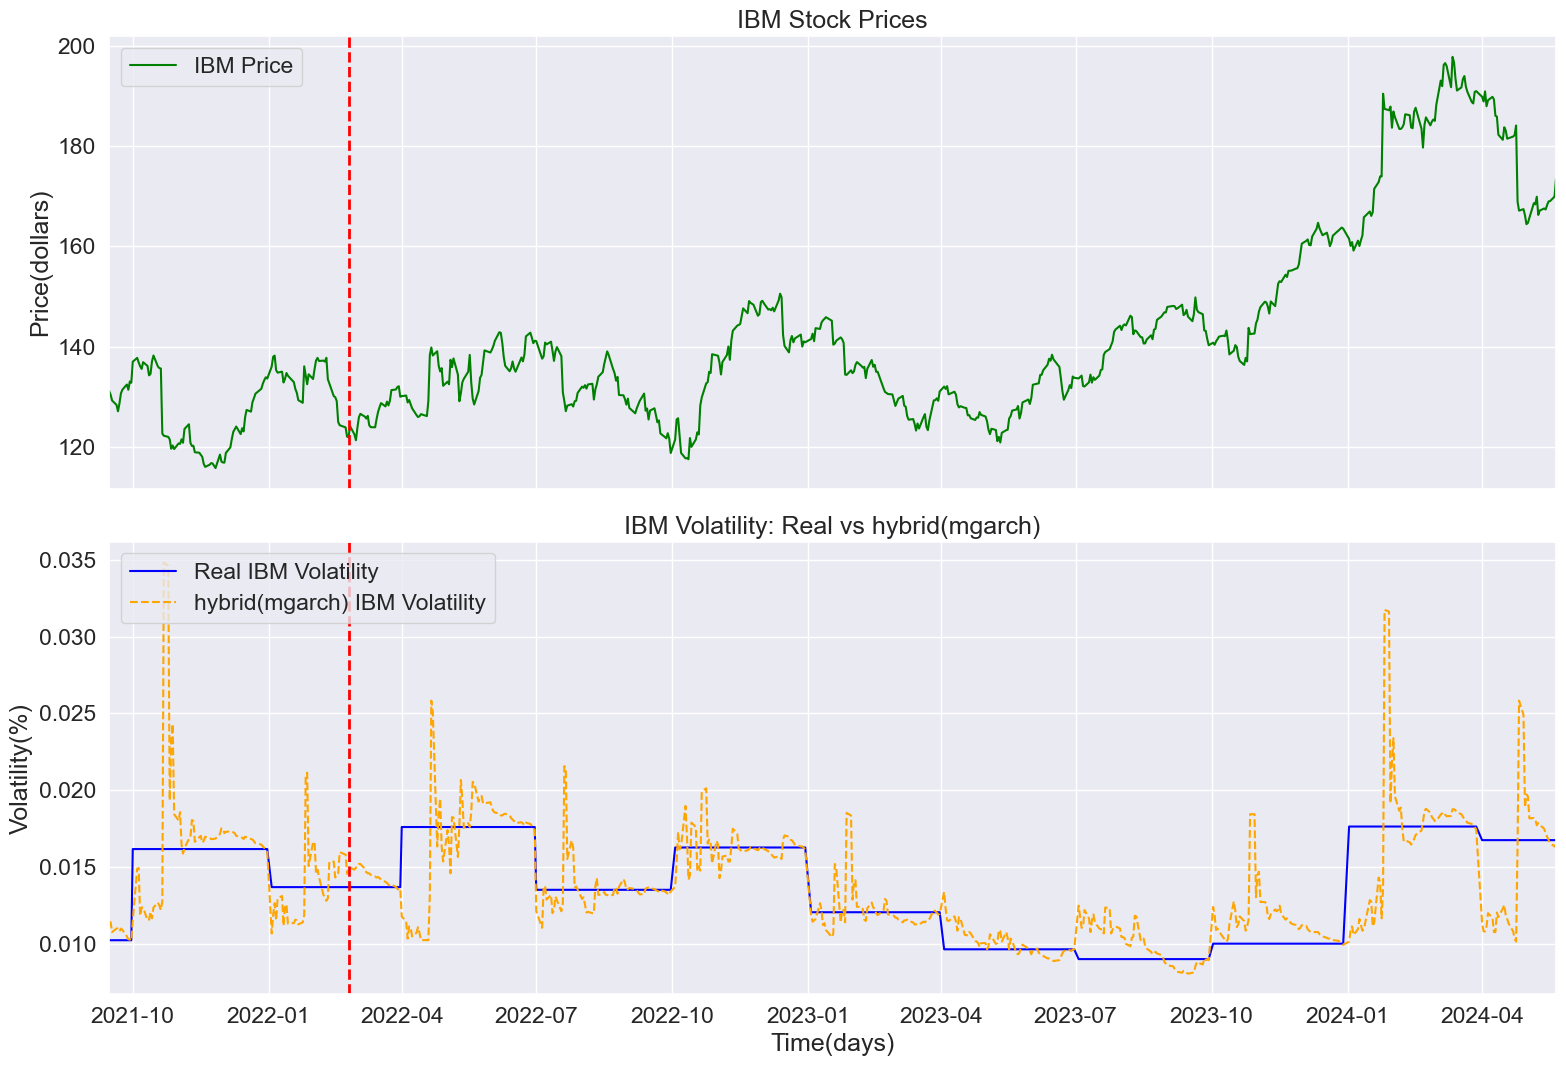

In [39]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "hybrid(mgarch)")

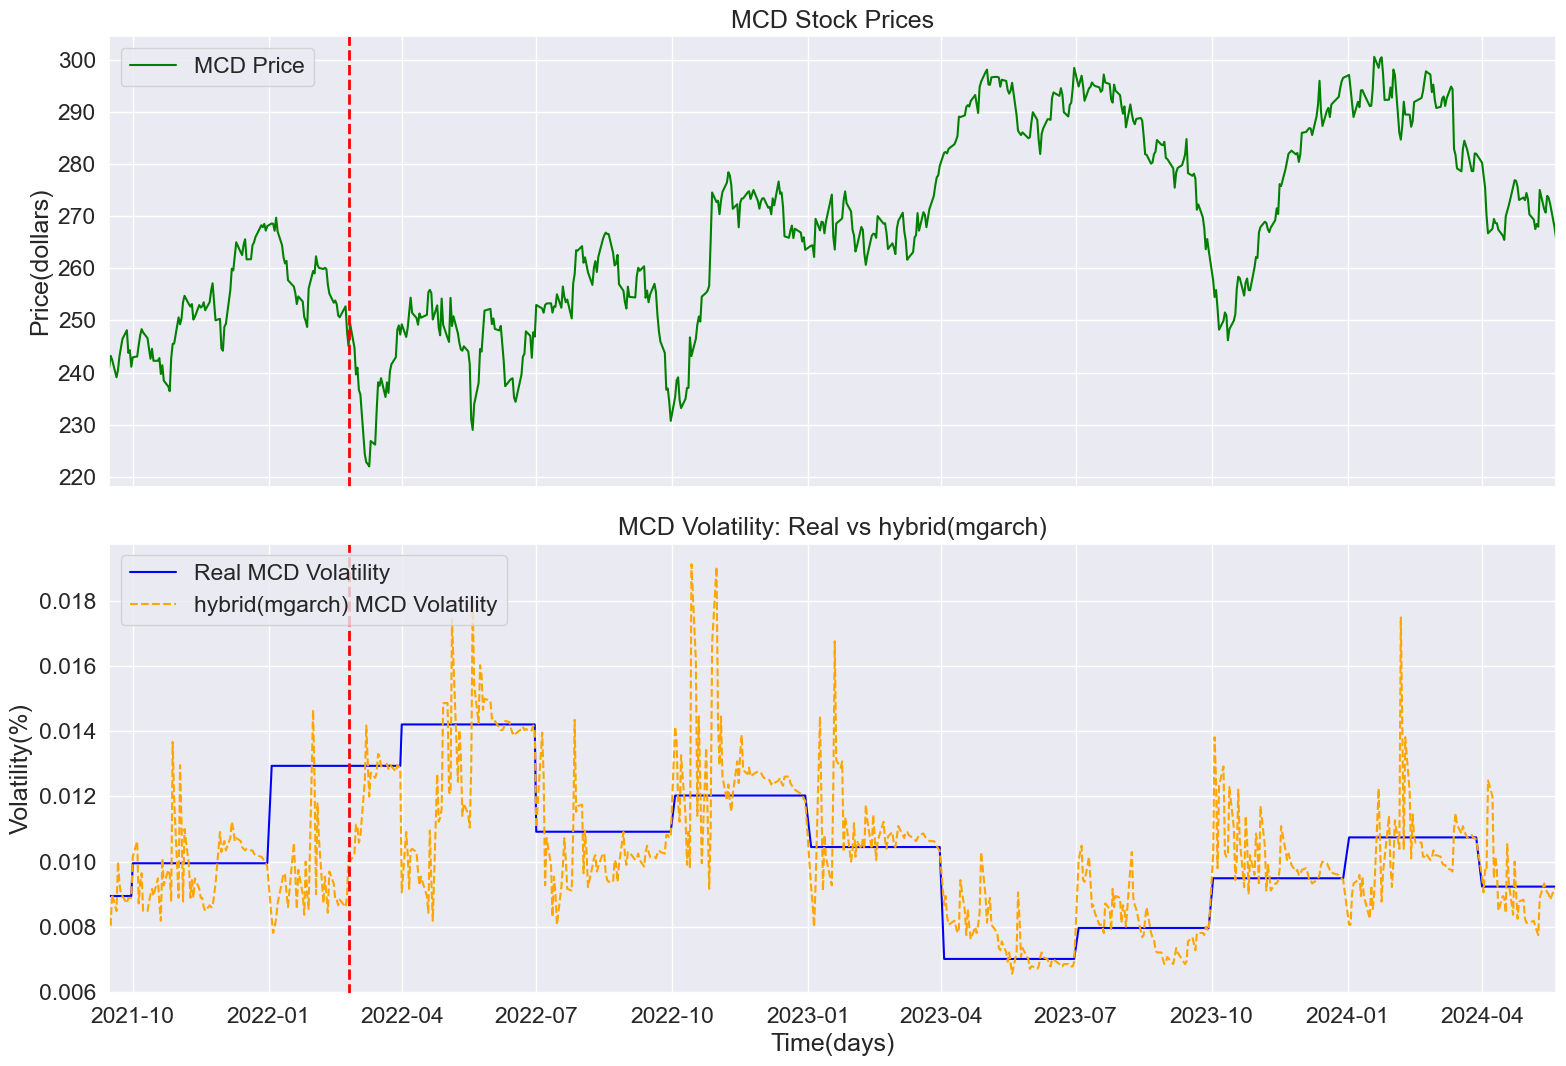

In [40]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "hybrid(mgarch)")

size of the first predictor: 656
size of the second predictor: 656
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


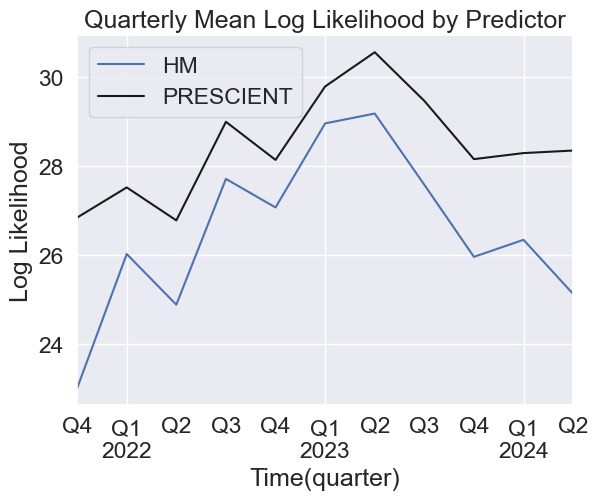

logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodHM: 26.500
stdLoglikelihoodHM: 1.700
maxLoglikelihoodHM: 29.200
logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodPRESCIENT: 28.400
stdLoglikelihoodPRESCIENT: 1.100
maxLoglikelihoodPRESCIENT: 30.600


meanRegret: 1.900
stdRegret: 0.900
maxRegret: 3.800
lenght of prescientDict:  3620
lenght of hybridDict:  675
lenght of predictorDict:  656

HM RMSE
mean: 0.0268106012
std: 0.0207080961
max: 0.0884872594
lenght of rmses:  11
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.08848725942610579, Timestamp('2022-03-31 00:00:00'): 0.039321539131462704, Timestamp('2022-06-30 00:00:00'): 0.028796879609601176, Timestamp('2022-10-02 00:00:00'): 0.01828198072193585, Timestamp('2023-01-02 00:00:00'): 0.019717321398008268, Timestamp('2023-04-02 00:00:00'): 0.013704449662954872, Timestamp('2023-07-02 00:00:00'): 0.014939066800603982, Timestamp('2023-10-01 00:00:00'): 0.017921636175946137, Timestamp('20

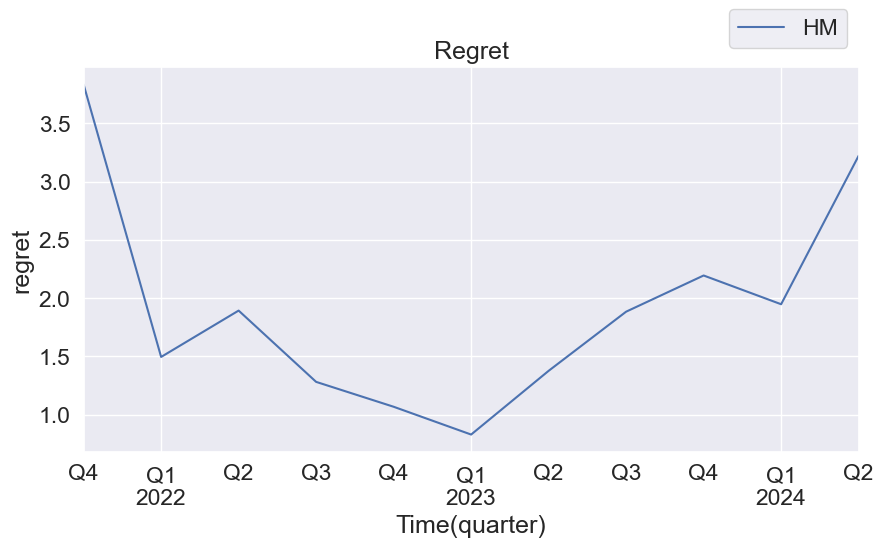

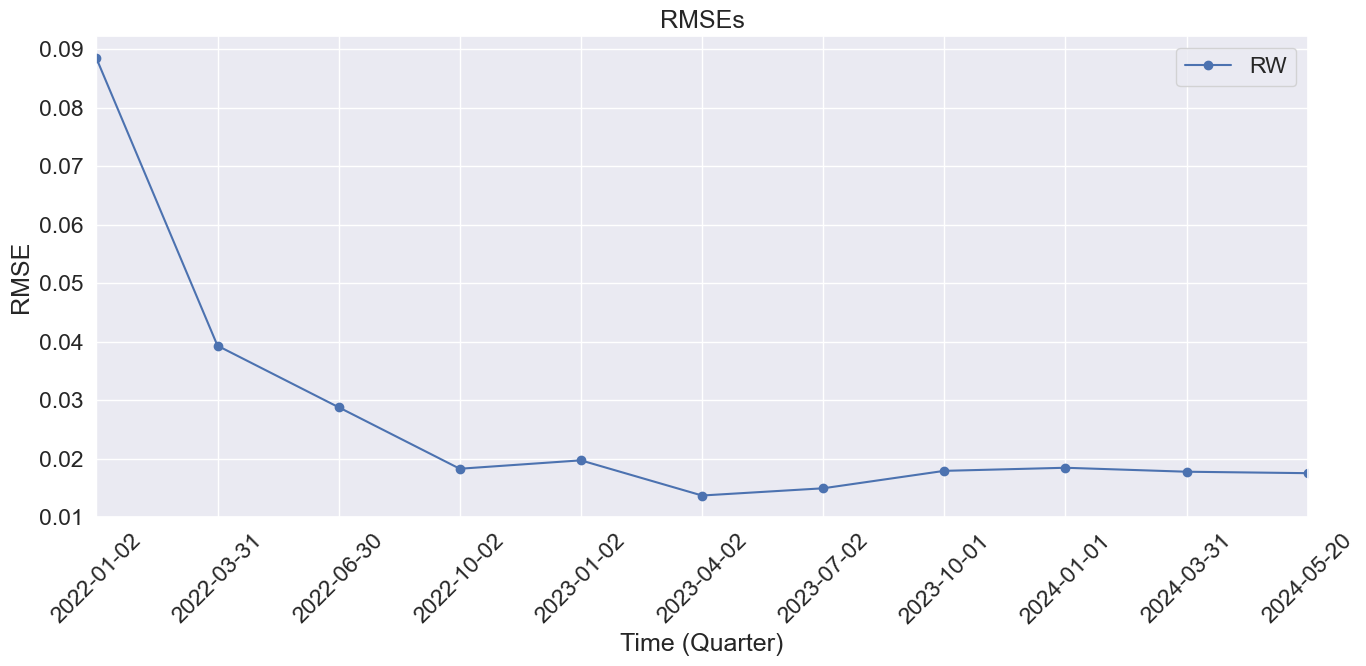

lenght of volatility_dict_aapl:  656
lenght of volatility_dict_aaapl_hybrid:  656
lenght of RMSEs_aapl:  11
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.0019528859531426155, Timestamp('2022-03-31 00:00:00'): 0.002388327284521932, Timestamp('2022-06-30 00:00:00'): 0.005060641960131844, Timestamp('2022-10-02 00:00:00'): 0.002414544175391376, Timestamp('2023-01-02 00:00:00'): 0.0035029019447297334, Timestamp('2023-04-02 00:00:00'): 0.00203002866816141, Timestamp('2023-07-02 00:00:00'): 0.0022254321866117476, Timestamp('2023-10-01 00:00:00'): 0.0015572857835038833, Timestamp('2024-01-01 00:00:00'): 0.002574105789317679, Timestamp('2024-03-31 00:00:00'): 0.0015648756306502986, Timestamp('2024-05-20 00:00:00'): 0.0019134384612272183}


RMSEs for AAPL
mean: 0.0024713153
std: 0.0009668003
max: 0.0050606420


RMSEs for IBM
mean: 0.0024597626
std: 0.0012368741
max: 0.0043978364


RMSEs for MCD
mean: 0.0015142311
std: 0.0006742749
max: 0.0030285010
Stored 'hybridMgarchDictFiltered'

In [41]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

hybridDictionary = predictors[0]

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDictionary = {k: hybridDictionary[k] for k in list(hybridDictionary)[19:]}
predictors[0] = hybridDictionary

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(testDataWithPercentageChange, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_filtered = {k: v for k, v in volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_filtered = {k: v for k, v in volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_filtered = {k: v for k, v in volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_filtered = {k: v for k, v in volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_filtered = {k: v for k, v in volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_filtered = {k: v for k, v in volatility_dict_wmt.items() if k >= startDAte}

volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_wmt.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

# store the covariance matrixes dict of the filtered dataset
hybridMgarchDictFiltered = predictors[0]

# store the covariance matrixes dict of the filtered dataset(just for the hibryd mgarch)
%store hybridMgarchDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [42]:
# create a dictionary for the volatilities of the prescient predictor
hybrid_mgarch_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_mgarch_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_mgarch_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_mgarch_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

if numberOfAssets == 6:
    hybrid_mgarch_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_mgarch_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_mgarch_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered

if numberOfAssets == 9:
    hybrid_mgarch_volatilities["KO"] = volatility_dict_ko_hybrid_filtered
    hybrid_mgarch_volatilities["PEP"] = volatility_dict_pep_hybrid_filtered
    hybrid_mgarch_volatilities["JNJ"] = volatility_dict_jnj_hybrid_filtered
    hybrid_mgarch_volatilities["ORCL"] = volatility_dict_orcl_hybrid_filtered
    hybrid_mgarch_volatilities["PFE"] = volatility_dict_pfe_hybrid_filtered
    hybrid_mgarch_volatilities["WMT"] = volatility_dict_wmt_hybrid_filtered

# store the dictionary
%store hybrid_mgarch_volatilities

Stored 'hybrid_mgarch_volatilities' (dict)
